In [1]:
session = 1

cuda_i = 0
wm     = 1
nni    = 106

import time
import random
from datetime import datetime
import zipfile
import pandas as pd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import torch
start_notebook_time = time.time()

now = datetime.now()
date_time_now = now.strftime("%m_%d_%Y_%H_%M_%S")

nni = f'{nni}_{date_time_now}'

logging.basicConfig(filename=f'loging_wm{wm}_cuda{cuda_i}_i_{nni}.txt',
                        filemode='a',
                        format='%(asctime)s, %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)
logging.info("Running")
logger = logging.getLogger('urbanGUI')

def print_logging_info(*LL):
                print(LL)
                logging.info(''.join( [str(x) for x in  [LL] ] ))

# What is about  ?

Notebook for CayleyPy project - ML-methods for group theory and Cayley graphs pathfiding.

See papers: https://arxiv.org/abs/2502.18663 , https://arxiv.org/abs/2502.13266 




# Main Params

# Preliminaries

In [ ]:
CFG = {}

###########################################################################
# What permutation group:
###########################################################################
CFG['n_permutations_length']  = 52 #  n_permutations_length
n_permutations_length = CFG['n_permutations_length']

# 3086 lr1e-5 e16000rw1k nbt8 bsnbt32 n16b1 rwlenDiam

###########################################################################
# Random walks paramsWhat is about ?
###########################################################################
CFG['random_walks_type'] =  'non-backtracking-beam' # 'simple' #    'simple' #
CFG['n_random_walk_length']  =  int ( n_permutations_length*(n_permutations_length-1)/2 )  #  00#600#

CFG['n_random_walks_to_generate']  =  1024 # Affects training time - linearly
CFG['n_random_walks_steps_back_to_ban']  =  8 #   used only for non-backtracking random walks

###########################################################################
# Neural Net params
###########################################################################
CFG['model_type'] = 'MLP'
CFG['list_layers_sizes'] = [1024, 1024, 1024] #  [128, 128, 128]
CFG['n_epochs'] = 100
CFG['batch_size'] =  1024#  8192# 64#
CFG['lr'] = 1e-7

CFG['optimizer_type'] = 'AdamW'
CFG['weight_decay'] = 1e-5 # used for AdamW
CFG['scheduler'] = False #  True

###########################################################################
# DQN training
###########################################################################
CFG['n_epochs_dqn'] = 4000 # 5000
CFG['milestones_dqn'] = [4000, 4500]
CFG['flag_dqn_round'] = False
CFG['n_random_walks_to_generate_dqn'] = 1024 # CFG['n_random_walks_to_generate']

###########################################################################
# Beam search
###########################################################################
CFG['beam_search_torch'] = True # Launch or not fast version of beam search (currently not returns paths - just lenght)
CFG['beam_search_Fironov'] = False # Launch or not Fironov's version of beam search (better for tests)

# beam_width - key param of beam search:
CFG['beam_width']  =  1# 2**16 # 8192#  1024 # 100#  2**17
# Steps limit in beam search:
CFG['n_steps_limit']  =  4*n_permutations_length*n_permutations_length
# Coefficient to combine previous cost and new value typically 0...1 (attenuation of history)
CFG['alpha_previous_cost_accumulation']  =  0
# What heuristics to use:
CFG['beam_search_models_or_heuristics'] =  'model_torch'; # 'Hamming' , 'model_with_predict': # Catboost or Sklearn
# Specific to LRX param: to apply X or not depending on v0 and v1
# Condition proposed by S.Fironov - it is rather natural, but seems not always optimal
CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted'] = False # False # True
CFG['n_beam_search_steps_back_to_ban'] = 32 # True

###########################################################################
# What to solve:
###########################################################################
CFG['solve_random_or_longest_state'] =  'solve_LRX_longest' # 'solve_random_state'

###########################################################################
###########################################################################
# Print/Save CFG
###########################################################################
print_logging_info(CFG)
print_logging_info()
for k in CFG:
    print_logging_info(k,':',CFG[k])

# Save CFG-dictionary to a JSON file
import json
with open('CFG.json', 'w') as json_file:
    json.dump(CFG, json_file)


({'n_permutations_length': 52, 'random_walks_type': 'non-backtracking-beam', 'n_random_walk_length': 1326, 'n_random_walks_to_generate': 1024, 'n_random_walks_steps_back_to_ban': 8, 'model_type': 'MLP', 'list_layers_sizes': [1024, 1024, 1024], 'n_epochs': 100, 'batch_size': 1024, 'lr': 1e-07, 'optimizer_type': 'AdamW', 'weight_decay': 1e-05, 'scheduler': False, 'n_epochs_dqn': 510, 'milestones_dqn': [4000, 4500], 'flag_dqn_round': False, 'n_random_walks_to_generate_dqn': 1024, 'beam_search_torch': True, 'beam_search_Fironov': False, 'beam_width': 1, 'n_steps_limit': 10816, 'alpha_previous_cost_accumulation': 0, 'beam_search_models_or_heuristics': 'model_torch', 'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False, 'n_beam_search_steps_back_to_ban': 32, 'solve_random_or_longest_state': 'solve_LRX_longest'},)
()
('n_permutations_length', ':', 52)
('random_walks_type', ':', 'non-backtracking-beam')
('n_random_walk_length', ':', 1326)
('n_random_walks_to_generate', ':', 1024)
('n

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import pickle

import time
t0start = time.time()

import matplotlib.pyplot as plt
import seaborn as sns

import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print_logging_info(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#!rm -rf /home/datalab/nfs/group_teory/1card_30may_MrN/2_cuda0*

In [5]:
#experiment_path = "/kaggle/working/"
folder=f'1card_30may_MrN/{wm}_cuda{cuda_i}_i_{nni}'
experiment_path = f"/home/datalab/nfs/group_teory/{folder}/"
os.makedirs(experiment_path, exist_ok=True)

# Generators

In [6]:
n = CFG['n_permutations_length'] # n_permutations_length
print_logging_info('n=', n)

def get_LRX_moves(n):
    L = np.array( list(np.arange(1,n)) + [0])
    R = np.array( [n-1] + list(np.arange(n-1)) )
    X = np.array( [1,0] + list(np.arange(2,n)) )
    return L,R,X
L,R,X = get_LRX_moves(n)
dict_generators = {'L':L,'R':R,'X':X }

list_generators = [L,R,X ]

device = torch.device(f"cuda:{cuda_i}" if torch.cuda.is_available() else "cpu")
# Reformat generators in torch 2d array
dtype_generators = torch.int64
tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )
print_logging_info('tensor_generators.shape:', tensor_generators.shape)


print_logging_info('L[X[R]]:', L[X[R]])
print_logging_info('(L[X])[R]:', (L[X])[R])

print_logging_info(len(list_generators), list_generators)
print_logging_info('S_n, n=', len(list_generators[0] ) )

('n=', 52)
('tensor_generators.shape:', torch.Size([3, 52]))
('L[X[R]]:', array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51]))
('(L[X])[R]:', array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51]))
(3, [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        0]), array([51,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41,

/tmp/ipykernel_13527/3867323629.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )


# Technical params - device, dtype

In [7]:
device = torch.device(f"cuda:{cuda_i}" if torch.cuda.is_available() else "cpu")

n_unique_symbols_in_states = len(list_generators[0] )#  len( set(state_rw_start) )
dtype =  torch.uint8 if n_unique_symbols_in_states <= 256 else torch.uint16

## Hash vector

In [8]:
# Preprare vector which will used for hashing - to avoid revisiting same states
state_size = len(list_generators[0] )
max_int =  int( (2**62) )
dtype_for_hash = torch.int64
# if vec_hasher == 'Auto':
vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)

# Destination state ("solved state" , "identity of group")

In [9]:
state_destination = torch.arange( len(list_generators[0]) , device = device, dtype =  dtype_generators  )


# Random Walks generators - train set creators

## Main Wrapper

In [10]:
def random_walks(generators , n_random_walk_length,  n_random_walks_to_generate,    state_rw_start = '01234...',
                 n_random_walks_steps_back_to_ban = 0, random_walks_type = 'simple', # 'non-backtracking-beam',
                 device='Auto', dtype = 'Auto' , vec_hasher = 'Auto', verbose = 0   ):
    '''
    Random walks on Cayley/Schreier graph of permutation group with generators: "generators",
    all starting from the same node (state): "state_rw_start".
    Length and number of trajectories - main params.

    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    X - 2d torch tensor, dimension 0 - index of state, dimension 1 - coordinates of states
    y - 1d torch tensor, dimension 0 - index of state - same as in X
    y[i] - number of rw-steps the state X[i,:] was achieved.

    Input:
    generators - generators (moves) to make random walks  (permutations),
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1
    n_random_walks_to_generate - how many random walks will run in parrallel
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times,
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]

    n_random_walks_steps_back_to_ban - "history depth" to store and ban revisting the previous states. (Used for non-backtracking random walks)
    '''

    if  random_walks_type == 'non-backtracking-beam':
        X,y = random_walks_nbt(generators=generators ,
                 n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate = n_random_walks_to_generate,
                 state_rw_start = state_rw_start, # '01234...',
                 n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban, random_walks_type = 'non-backtracking-beam',
                 device =  device, dtype = dtype , vec_hasher = vec_hasher, verbose = verbose   )
    else:
        X,y = random_walks_simple(generators=generators ,
                 n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate = n_random_walks_to_generate,
                 state_rw_start = state_rw_start, # '01234...',
                 device =  device, dtype = dtype ,  verbose = verbose   )

    return X,y

### Auxiliary function - many moves to many states

In [11]:
def get_neighbors(states, moves):
    """
    Some torch magic to apply all moves to all states at once
    Input:
    states: 2d torch array n_states x n_state_size - rows are states-vectors
    moves (int64): 2d torch array n_moves x  n_state_size - rows are permutations describing moves
    Returns:
    3d tensor all moves applied to all states, shape: n_states x n_moves x n_state_size
    Typically output is followed by .flatten(end_dim=1), which flattens to 2d array ( n_states * n_moves) x n_state_size
    """
    return torch.gather(
        states.unsqueeze(1).expand(states.size(0), moves.shape[0], states.size(1)),
        2,
        moves.unsqueeze(0).expand(states.size(0), moves.shape[0], states.size(1)))

## Simple random walks

In [12]:
def random_walks_simple(generators , n_random_walk_length,  n_random_walks_to_generate,
                        state_rw_start = '01234...',
                 device='Auto', dtype = 'Auto' , verbose = 0   ):

    '''
    Random walks on Cayley/Schreier graph of permutation group with generators: "generators",
    all starting from the same node (state): "state_rw_start".
    Length and number of trajectories - main params.

    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it
    X - 2d torch tensor, dimension 0 - index of state, dimension 1 - coordinates of states
    y - 1d torch tensor, dimension 0 - index of state - same as in X
    y[i] - number of rw-steps the state X[i,:] was achieved.

    Input:
    generators - generators (moves) to make random walks  (permutations),
        can be list of vectors or array with vstacked vectors

    n_random_walk_length - number of visited nodes, i.e. number of steps + 1
    n_random_walks_to_generate - how many random walks will run in parrallel
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times,
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]
    '''

    ##########################################################################################
    # Analyse input params and convert to stadard forms
    ##########################################################################################

    # device
    if device == 'Auto':
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{cuda_i}")
        else:
            device = torch.device("cpu")

    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, tuple):
        list_generators = list(generators)
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print_logging_info('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators" ' + str(type(generators)) )

    state_size = len(list_generators[0])
    all_moves = tensor_all_generators = torch.tensor( list_generators , device = device, dtype = torch.int64)
    n_generators = len(list_generators)

    if verbose >= 100:
        print_logging_info('state_size', state_size )


    # dtype
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        n_unique_symbols_in_states = state_size
    else:
        tmp = set( [int(i) for i in state_rw_start ]  ) # Number of unique elements in any iterator
        n_unique_symbols_in_states = len(tmp)
    if dtype == 'Auto':
        if n_unique_symbols_in_states <= 256:
            dtype = torch.uint8
        else:
            dtype = torch.uint16

    # Destination state
    if state_rw_start == '01234...':
        state_rw_start = torch.arange( state_size, device=device, dtype = dtype).reshape(-1,state_size)
    elif isinstance(state_destination, torch.Tensor ):
        state_rw_start =  state_destination.to(device).to(dtype).reshape(-1,state_size)
    else:
        state_rw_start = torch.tensor( state_destination, device=device, dtype = dtype).reshape(-1,state_size)

    array_of_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size ).clone()


    if verbose >= 100:
        print_logging_info('state_rw_start.shape:', state_rw_start.shape)
        print_logging_info('state_rw_start:',state_rw_start)
        print_logging_info(array_of_states.shape)
        print_logging_info( array_of_states[:3,:] )


    ##########################################################################################
    # Initializations
    ##########################################################################################

    # Output: X,y - states, y - how many steps we achieve them
    # Allocate memory:
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size,    device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length ,    device=device, dtype = torch.uint32 )

    if verbose >= 100:
        print_logging_info('X.shape',X.shape)


    # First portion of data  - just our state_rw_start state  multiplexed many times
    X[:n_random_walks_to_generate,:] = array_of_states
    y[:n_random_walks_to_generate] = 0

    # Technical to make array[ IX_array] we need  actually to write array[ range(N), IX_array  ]
    row_indices = torch.arange( array_of_states.shape[0] , device=device, dtype = dtype )
    row_indices = np.arange( array_of_states.shape[0] )[:, np.newaxis]

    # Main loop
    for i_step in range(1,n_random_walk_length):
        y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step
        IX_moves = np.random.randint(0, n_generators, size=n_random_walks_to_generate, dtype = int) # random moves indixes
        new_array_of_states = array_of_states[ row_indices , all_moves[IX_moves,:]] # all_moves[IX_moves,:] ]
        array_of_states = new_array_of_states
        X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = new_array_of_states


    if verbose >= 100:
        print_logging_info(array_of_states.shape, 'array_of_states.shape')
        print_logging_info(n_random_walk_length, 'n_random_walk_length', state_size,'state_size', '' )
        print_logging_info('Finished')
        print_logging_info(str(X)[:500] )
        print_logging_info(str(y)[:500] )

    return X,y

## Non-backtracking random walks

In [13]:

def random_walks_nbt(generators , n_random_walk_length,  n_random_walks_to_generate,    state_rw_start = '01234...',
                 n_random_walks_steps_back_to_ban = 0, random_walks_type = 'non-backtracking-beam',
                 device='Auto', dtype = 'Auto' , vec_hasher = 'Auto', verbose = 0   ):
    '''
    Generation of improved non-backtracking random walks on Cayley/Schreier graph of permutation group with generators: "generators",
    all starting from the same node (state): "state_rw_start". Lenght and number of trajectories - main params.

    Output:
    returns X,y: X - array of states, y - number of steps rw achieves it

    Input:
    generators - generators (moves) to make random walks  (permutations),
        can be list of vectors or array with vstacked vectors
    n_random_walk_length - number of visited nodes, i.e. number of steps + 1
    n_random_walks_to_generate - how many random walks will run in parrallel
    n_random_walks_steps_back_to_ban - "history depth" to store and ban revisting the previous states.
    state_rw_start - initial states for random walks - by default we will use 0,1,2,3 ...
        Can be vector or array
        If it is vector it will be broadcasted n_random_walks_to_generate times,
        If it is array n_random_walks_to_generate - input n_random_walks_to_generate will be ignored
            and will be assigned: n_random_walks_to_generate = rw_start.shape[0]

    Improvements over the standard non-backtracking.
    Goal of improvements -  "mix even faster" - number of random walks steps will be better related with actual distance on graph.
    Basically the procedure is very similar to beam search, except there is no goal function.
    So we can call it "non-backtracking-beam".

    1. Parameter n_random_walks_steps_back_to_ban -  "depth of history" - how many previous levels to remember and ban to visit again.

    2. Collective/beam baning the history - many trajectories at once are generated and we ban to visit any state from any trajectory visited before, that is each trajctory knows  the other trajectories and do not visit states visited by them

    3. Actually we ban non only visited states, but also "potentially visited" - that is 1-neigbours of current array of states will be banned

    Fast implementation - fast hashes:
    The time consuming operation is the check whether the newly obtained states we already visited or not.
    To make that operation fast we employ simple, but fast hashing for integer vectors - just their scalar product with the random vector - getting single int64 number as a hash. Due to large range of int64 collisions are not observed in practice. (It can be extended to hashing with two vectors getting two int64 - then collisions would be almost impossible - but there is no practical need for that - even if collission rarely happens it will it affect overall performance.)
    Finding common/non-common elements for two int64 hash vectors - can be done effectively by e.g. torch.isin command.
    (Other options explored here: https://stackoverflow.com/q/78896180/625396 https://stackoverflow.com/a/78634154/625396 )

    Fast implementation - applying many generators to many states/vectors at once:
    The fastest way to apply many permutations to many vectors at once is torch.gather command.
    Its interface migth not be so obvious.
    We pack it in the function get_neighbors
    See more details in the notebook: https://www.kaggle.com/code/alexandervc/permutations-numpy-torch-sympy-tutorial

    Techical detail:
    Sometimes we sacrifice non-backtracking - not to crash the code.
    We generate each step n_random_walks_to_generate states, in some small examples it may happen we are not able to find states which were not visited before - then we first take as much new states as we can and add to them states which are previously visited. Such situation is not expected to happen for large groups of our interest, and the option added not to crash code on small toy examples.

    '''
    t0 = time.time()
    ##########################################################################################
    # Processing/Reformating input params
    ##########################################################################################

    # device
    if device == 'Auto':
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{cuda_i}")
        else:
            device = torch.device("cpu")
    # Analyse input format of "generators"
    # can be list_generators, or tensor/np.array with rows - generators
    if isinstance(generators, list):
        list_generators = generators
    elif isinstance(generators, tuple):
        list_generators = list(generators)
    elif isinstance(generators, torch.Tensor ):
        list_generators = [ list(generators[i,:]) for i in range(generators.shape[0] ) ]
    elif isinstance(generators, np.ndarray ):
        list_generators = [list(generators[i,:]) for i in range(generators.shape[0] ) ]
    else:
        print_logging_info('Unsupported format for "generators"', type(generators), generators)
        raise ValueError('Unsupported format for "generators" ' + str(type(generators)) )
    state_size = len(list_generators[0])
    n_generators = len( list_generators )

    # dtype
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        n_unique_symbols_in_states = state_size
    else:
        tmp = set( [int(i) for i in state_rw_start ]  ) # Number of unique elements in any iterator
        n_unique_symbols_in_states = len(tmp)
    if dtype == 'Auto':
        if n_unique_symbols_in_states <= 256:
            dtype = torch.uint8
        else:
            dtype = torch.uint16

    # Destination state
    if (state_rw_start == '01234...') or (state_rw_start == 'Auto' ):
        state_rw_start = torch.arange( state_size, device=device, dtype = dtype).reshape(-1,state_size)
    elif isinstance(state_destination, torch.Tensor ):
        state_rw_start =  state_destination.to(device).to(dtype).reshape(-1,state_size)
    else:
        state_rw_start = torch.tensor( state_destination, device=device, dtype = dtype).reshape(-1,state_size)

    # Reformat generators in torch 2d array
    dtype_generators = torch.int64
    tensor_generators = torch.tensor( list_generators , device = device, dtype =  dtype_generators  )
    #print('tensor_generators.shape:', tensor_generators.shape)

    # Preprare vector which will used for hashing - to avoid revisiting same states
    max_int =  int( (2**62) )
    dtype_for_hash = torch.int64
    if vec_hasher == 'Auto':
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)


    ##########################################################################################
    # Initializations
    ##########################################################################################

    # Main variable in the loop - store current states: 2d torch tensor
    # Initialization via state_rw_start state - duplicatie it many (n_random_walks_to_generate) times
    array_current_states = state_rw_start.view(1, state_size  ).expand(n_random_walks_to_generate, state_size ).clone()

    # Output: X,y - states, y - how many steps we achieve them
    # Allocate memory:
    X = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , state_size, device=device, dtype = dtype )
    y = torch.zeros( (n_random_walks_to_generate)*n_random_walk_length , device=device, dtype = torch.uint32 )
    # First portion of data  - just our state_rw_start state  multiplexed many ( n_random_walks_to_generate ) times
    X[:n_random_walks_to_generate,:] = array_current_states
    y[:n_random_walks_to_generate] = 0

    # Hash initial states.
    if n_random_walks_steps_back_to_ban > 0:
        hash_initial_state = torch.sum( state_rw_start.view(-1, state_size  ) * vec_hasher, dim=1) # Compute hashes
        vec_hashes_current = hash_initial_state.expand( n_random_walks_to_generate * n_generators  , n_random_walks_steps_back_to_ban ).clone()
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        # Intialize index for hash storage
        # Newly obtained hash vectors will be stored in 2d array vec_hashes_current
        # The position/column for storage: i_cyclic_index_for_hash_storage
        i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_random_walks_steps_back_to_ban, i.e. from 0 to n_random_walks_steps_back_to_ban-1


    if verbose >= 100:
        print_logging_info('X.shape:',X.shape, 'y.shape:',y.shape)
        print_logging_info(array_current_states.shape)
        print_logging_info( array_current_states[:3,:] )

    ##########################################################################################
    # Main loop
    # 1. Create new states from current making ALL possible moves - thus number of states will be more than we need
    # 2. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
    # 2.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
    # 2.2. Choose only those states which hashes are new - not in the stored history of hashes
    # 3. Select only desired number of states - random subset of desired size: n_random_walks_to_generate subset
    # 4. Store these states into output X,y
    # 5. Update hash storage
    ##########################################################################################
    i_step_corrected = 0
    for i_step in range(1,n_random_walk_length):
        t_moves = t_hash = t_isin =  0; t_full_step = time.time() # Time profiling
        t_unique_els = 0 # not used currently

        # 1 Create new states:
        # Apply all generators to all current states at once
        # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
        t1 = time.time()
        array_new_states = get_neighbors(array_current_states,tensor_generators  ).flatten(end_dim=1) # Flatten converts 3d array to 2d
        t_moves += (time.time() - t1)

        # 2.1 Compute hashes
        # Compute hash. For non-backtracking - selection not visited states before.
        t1 = time.time()
        vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes
        # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
        t_hash += (time.time() - t1)
        #  print('hashed', t_hash )

        if n_random_walks_steps_back_to_ban > 0:
            # 2.2 Select only states not seen before
            # Nonbacktracking - select states not visited before
            t1 = time.time()
            mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
            t_isin += (time.time() - t1)
            mask_new_sum = mask_new.sum().item()
            if mask_new_sum >= n_random_walks_to_generate:
                # Select only new states - not visited before
                array_new_states = array_new_states[mask_new,:]
                i_step_corrected += 1
            else:
                # Exceptional case - should not happen for large group of interest
                # The case: can not find enough new states - will take old also not to crash the code
                if mask_new_sum > 0:
                    i_tmp0 = int( np.ceil( n_random_walks_to_generate/mask_new_sum ))
                    array_new_states = array_new_states[mask_new,:].repeat(i_tmp0, 1)[:n_random_walks_to_generate,:]
                    i_step_corrected += 1
                else:
                    # do not move
                    array_new_states = array_current_states #
                    i_step_corrected = i_step_corrected

        # 3. Select only desired number of states
        # Select only n_random_walks_to_generate (with preliminary shuffling)
        # Update current states with them
        perm = torch.randperm(array_new_states.size(0), device = device)
        array_current_states = array_new_states[perm][:n_random_walks_to_generate]

        # 4. Store results in final output
        y[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate  ] = i_step_corrected
        X[ (i_step)*n_random_walks_to_generate : (i_step+1)*n_random_walks_to_generate , : ] = array_current_states

        if n_random_walks_steps_back_to_ban>0:
            # 5. Update hash storage
            # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
            # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
            # Which might not always be the case since random walk may create loops.
            # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
            # Thus we improve chances that the next states will increase the true graph distance
            i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_random_walks_steps_back_to_ban
            vec_hashes_current[:, i_cyclic_index_for_hash_storage ] = vec_hashes_new

        if verbose >= 10:
            t_full_step = time.time()-t_full_step
            print_logging_info(i_step,'i_step', 'array_current_states.shape:',array_current_states.shape, 'Time %.3f'%(time.time()-t0),
                 't_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves ,
                  t_hash , t_isin , t_unique_els, t_full_step) )

    return X,y

## Test random walks

In [14]:
%%time
X_tmp, y_tmp = random_walks(list_generators ,
        n_random_walk_length = 300,  n_random_walks_to_generate =  1_000,
                        n_random_walks_steps_back_to_ban = 10,
                           random_walks_type =  'simple') #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print_logging_info('X:')
print_logging_info('X.shape', X_tmp.shape)
print_logging_info(X_tmp)
print_logging_info(y_tmp.shape)
print_logging_info(y_tmp)

('X:',)
('X.shape', torch.Size([300000, 52]))
(tensor([[ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        ...,
        [48, 46, 49,  ..., 40, 44, 50],
        [10, 15, 11,  ...,  7,  8,  9],
        [ 3, 49, 48,  ..., 50, 45, 51]], device='cuda:0', dtype=torch.uint8),)
(torch.Size([300000]),)
(tensor([  0,   0,   0,  ..., 299, 299, 299], device='cuda:0',
       dtype=torch.uint32),)
CPU times: user 40 ms, sys: 30 ms, total: 70 ms
Wall time: 67.8 ms


In [15]:
%%time
X_tmp, y_tmp = random_walks(list_generators ,
        n_random_walk_length = 300,  n_random_walks_to_generate =  1_000,
                        n_random_walks_steps_back_to_ban = 1,
                           random_walks_type =  'non-backtracking-beam') #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print_logging_info('X:')
print_logging_info('X.shape', X_tmp.shape)
print_logging_info(X_tmp)
print_logging_info(y_tmp.shape)
print_logging_info(y_tmp)


('X:',)
('X.shape', torch.Size([300000, 52]))
(tensor([[ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        ...,
        [ 1,  0,  3,  ..., 51,  4,  5],
        [16, 17, 19,  ..., 12, 14, 15],
        [37, 41, 40,  ..., 36, 38, 39]], device='cuda:0', dtype=torch.uint8),)
(torch.Size([300000]),)
(tensor([  0,   0,   0,  ..., 299, 299, 299], device='cuda:0',
       dtype=torch.uint32),)
CPU times: user 143 ms, sys: 69.7 ms, total: 213 ms
Wall time: 212 ms


In [16]:
%%time
random_walks_type = CFG['random_walks_type']
n_random_walk_length = CFG['n_random_walk_length']
n_random_walks_to_generate = CFG['n_random_walks_to_generate']
n_random_walks_steps_back_to_ban = CFG['n_random_walks_steps_back_to_ban']

X_tmp, y_tmp = random_walks(list_generators ,
        n_random_walk_length = n_random_walk_length,  n_random_walks_to_generate =  n_random_walks_to_generate,
                        n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban,
                           random_walks_type =  random_walks_type ) #,    rw_start = None,                  #device=device, dtype = dtype , verbose = 0   )

print_logging_info('X:')
print_logging_info('X.shape', X_tmp.shape)
print_logging_info(X_tmp)
print_logging_info(y_tmp.shape)
print_logging_info(y_tmp)

('X:',)
('X.shape', torch.Size([1357824, 52]))
(tensor([[ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        [ 0,  1,  2,  ..., 49, 50, 51],
        ...,
        [38, 42, 34,  ..., 43, 41, 48],
        [ 4,  3,  7,  ...,  2,  9,  5],
        [43, 50, 41,  ..., 47, 46, 34]], device='cuda:0', dtype=torch.uint8),)
(torch.Size([1357824]),)
(tensor([   0,    0,    0,  ..., 1325, 1325, 1325], device='cuda:0',
       dtype=torch.uint32),)
CPU times: user 579 ms, sys: 1.52 ms, total: 580 ms
Wall time: 580 ms


# Define the neural net

In [17]:
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim
from torch import nn
import torch.optim as optim
if CFG['model_type'] == 'MLP':
    class Net(nn.Module):
        """
            layer_sizes (list of int):
                A list defining the number of neurons in each hidden layer. The length of the list determines
                the number of hidden layers, and each element specifies the size of that layer.
                Example: [32, 16, 8] creates 3 hidden layers with 32, 16, and 8 neurons respectively and nn.ReLU() activations between.
            """
        def __init__(self, input_size, hidden_dims, num_classes_for_one_hot):
            super(Net, self).__init__()
            self.num_classes_for_one_hot = num_classes_for_one_hot
            self.input_layer_size_for_one_hot = input_size * num_classes_for_one_hot

            layers = []
            in_features = self.input_layer_size_for_one_hot
            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(in_features, hidden_dim))
                layers.append(nn.LayerNorm(hidden_dim))
                layers.append(nn.ReLU())
                # layers.append(nn.Tanh())
                in_features = hidden_dim

            layers.append(nn.Linear(in_features, 1))
            self.layers = nn.Sequential(*layers)

        def forward(self, x):
            x = torch.nn.functional.one_hot(x.long(), num_classes=self.num_classes_for_one_hot) \
            .float().flatten(start_dim=-2)
            return self.layers(x)

    layers = CFG['list_layers_sizes']
    print_logging_info(layers)
    input_size = CFG['n_permutations_length']
    n_unique_symbols_in_states = n_permutations_length
    # Creating a model
    model = Net( input_size, hidden_dims=layers, num_classes_for_one_hot = n_unique_symbols_in_states).to(device)

([1024, 1024, 1024],)


In [18]:
%%time
def get_model_memory(model):
    total_params = sum(p.numel() * p.element_size() for p in model.parameters())
    total_buffers = sum(b.numel() * b.element_size() for b in model.buffers())

    total_memory = total_params + total_buffers  # Total memory in bytes
    return total_memory

print_logging_info("model memory:", get_model_memory(model) )
try:
    print_logging_info(f"Memory allocated: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
    print_logging_info(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")
except Exception as e:
    print_logging_info(f"Exception occurred: {e}")

('model memory:', 19505156)
('Memory allocated: 92.04 MB',)
('Max memory allocated: 92.04 MB',)
CPU times: user 862 μs, sys: 0 ns, total: 862 μs
Wall time: 789 μs


In [19]:
def get_model_inf(CFG):

    str_modeling_inf = ''
    if 'model_type' in CFG.keys():
        str_modeling_inf += str( CFG['model_type'] )
        flag_loc = 'pretrained' not in CFG['model_type']
        flag_loc = flag_loc & ( CFG['model_type'] not in  ['MLP_Jalal_pretrained',  'MLP_Jalal', 'MLP_Vlad',  'MLP_Liuda'])
        if flag_loc:
            if 'list_layers_sizes' in CFG.keys():
                for t in CFG['list_layers_sizes']:
                    str_modeling_inf += '_'+str(t)
            if 'n_epochs' in  CFG.keys():
                str_modeling_inf += '_epochs'+str(CFG['n_epochs'])
            if 'n_random_walk_length' in CFG.keys():
                str_modeling_inf += '_rwlen'+str(CFG['n_random_walk_length'])
            if 'n_random_walks_to_generate' in CFG.keys():
                str_modeling_inf += '_n_rw'+str(CFG['n_random_walks_to_generate'])

    return str_modeling_inf

str_modeling_inf = get_model_inf(CFG)
print_logging_info('str_modeling_inf:',str_modeling_inf)

('str_modeling_inf:', 'MLP_1024_1024_1024_epochs100_rwlen1326_n_rw1024')


In [20]:
path = [
    'L', 'L', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'R', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L',
    'X', 'L', 'X', 'R', 'X', 'R', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'L', 'X', 'L', 'L', 'X', 'L', 'L', 'X', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
    'L', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'L', 'L', 'L', 'L', 'L', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'L', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'R', 'X', 'R', 'X', 'R',
    'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X',
    'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'R', 'X', 'L',
    'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X',
    'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L', 'X', 'L',
    'X', 'L', 'X'
]

## Params, Loss and Optimizer 

In [21]:

n_epochs = CFG['n_epochs']
batch_size = CFG['batch_size']

#################################################################################
# Loss function
#################################################################################
criterion = nn.MSELoss()


#################################################################################
# Optimizer
#################################################################################
#lr=0.001


if ('lr' in CFG.keys()) and ( isinstance( CFG['lr'], float  )  ) :
    lr = CFG['lr']
print_logging_info('lr:',lr)

#CFG['optimizer_type'] = 'AdamW'
# CFG['weight_decay'] = 1e-5
# CFG['scheduler'] = True
optimizer_type = CFG.get('optimizer_type', 'Adam')

if optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters() , lr=lr)

elif optimizer_type == 'AdamW':
    weight_decay = 1e-5 # Default
    if ('weight_decay' in CFG.keys()) and ( isinstance( CFG['weight_decay'], float  )  ) :
        weight_decay = CFG['weight_decay']
    print_logging_info('weight_decay:',weight_decay)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay= weight_decay )

if  CFG['scheduler'] == True:
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.8, verbose=True)
    print_logging_info('scheduler: milestones')
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=CFG['milestones_dqn'], gamma=0.1)


('lr:', 1e-07)
('weight_decay:', 1e-05)


In [22]:
random_walks_type = CFG['random_walks_type']
n_random_walk_length = CFG['n_random_walk_length']
n_random_walks_to_generate = CFG['n_random_walks_to_generate']
n_random_walks_steps_back_to_ban = CFG['n_random_walks_steps_back_to_ban']

print_logging_info('n_epochs:',n_epochs,'batch_size:',batch_size,'n_random_walks_to_generate:',n_random_walks_to_generate,
     'n_random_walk_length:',n_random_walk_length)

('n_epochs:', 100, 'batch_size:', 1024, 'n_random_walks_to_generate:', 1024, 'n_random_walk_length:', 1326)


## State to be solved

In [23]:
%%time
#state_destination = torch.arange( len(list_generators[0] ), dtype = dtype, device = device )
print_logging_info('state_destination:', state_destination)

# solve_random_or_longest_state = 'solve_random_LRX_longest'
# solve_random_or_longest_state = 'solve_random_state'
solve_random_or_longest_state = CFG['solve_random_or_longest_state']
print_logging_info('solve_random_or_longest_state:',solve_random_or_longest_state)
if solve_random_or_longest_state == 'solve_random_state':
    n_scrambles_starting_state = len(list_generators)**3*100 #1000
    state_start = state_destination.clone()
    for k in range(n_scrambles_starting_state):
        IX_move = np.random.randint(0, len(list_generators), dtype = int) # random moves indixes
        state_start = state_start[ list_generators[IX_move]] # all_moves[IX_moves,:] ]
else:
    n = len(list_generators[0])
    p = np.arange(n)
    # Swap (0,2)
    p[0], p[1] = p[1], p[0]
    i = 2
    while i < n-i+1:
        #print(i, n-i+1)
        p[i], p[n-i+1] = p[n-i+1], p[i]
        i += 1
    permutation_longest = torch.tensor( p , dtype = dtype, device = device )
    state_start = permutation_longest
    print_logging_info('permutation_LRX_longest:', permutation_longest)

#print('state_destination:', state_destination)
print_logging_info('state_start (state to be solved): ', state_start)


('state_destination:', tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
       device='cuda:0'))
('solve_random_or_longest_state:', 'solve_LRX_longest')
('permutation_LRX_longest:', tensor([ 1,  0, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36,
        35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18,
        17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
       device='cuda:0', dtype=torch.uint8))
('state_start (state to be solved): ', tensor([ 1,  0, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36,
        35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18,
        17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
       device='cuda:0', dtype=torch.uint8))
CPU times: user 6.47 ms, sys: 0 ns, total

# Modified DQN training 

In [24]:
n_permutations_length, n_random_walk_length

(52, 1326)

('n_epochs:', 510)
('epoch:', 0, 'train_loss:', 0.04978700826818273, 'Time:', 6.37, 'RW 0.59', 'Bellman 2.56', 'Train 3.19')


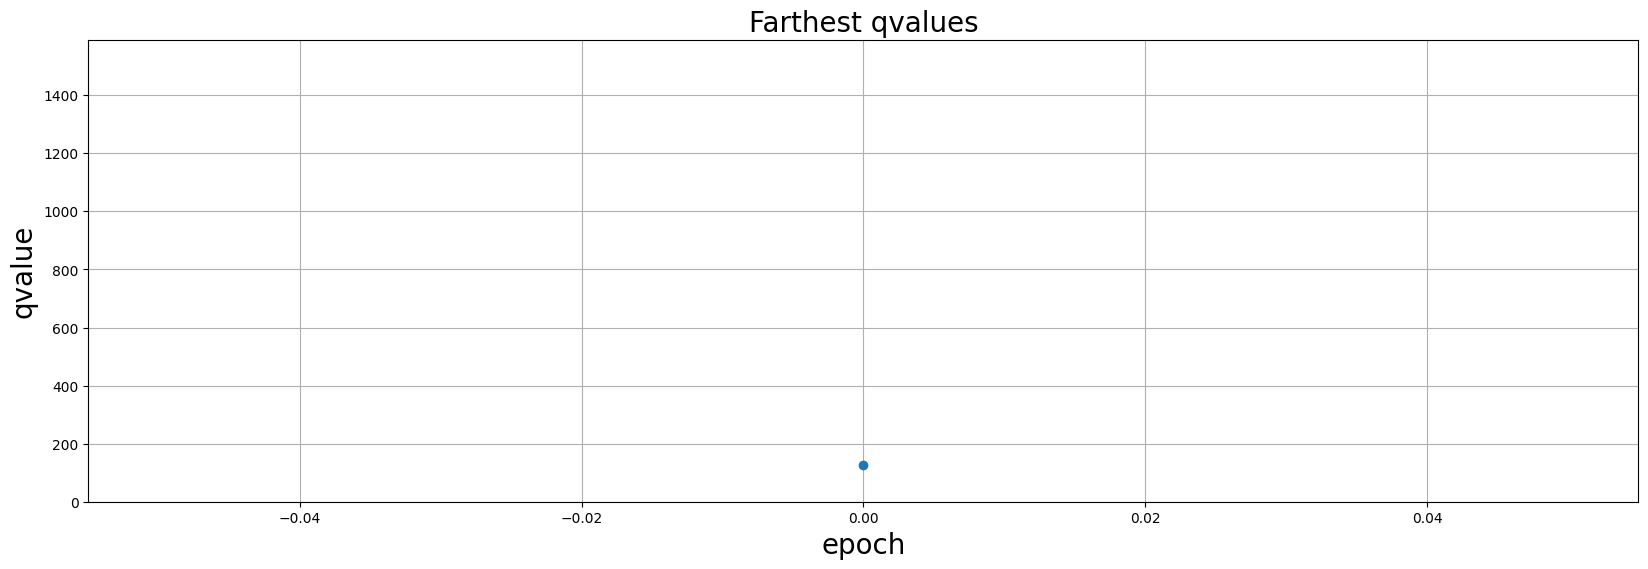

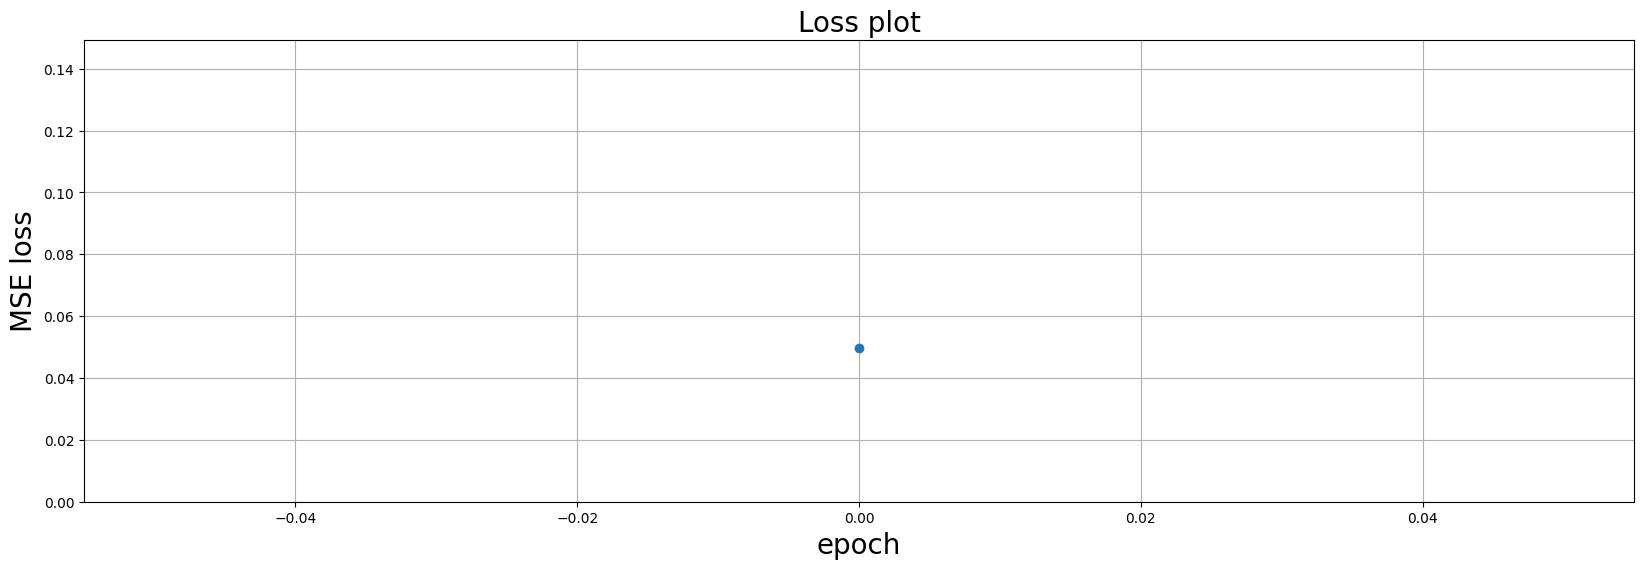

('epoch:', 10, 'train_loss:', 0.0003214780788967083, 'Time:', 68.09, 'RW 0.58', 'Bellman 2.41', 'Train 3.12')
('epoch:', 20, 'train_loss:', 2.3367168141048557e-06, 'Time:', 129.96, 'RW 0.58', 'Bellman 2.41', 'Train 3.15')
('epoch:', 30, 'train_loss:', 1.3981093449623116e-06, 'Time:', 192.04, 'RW 0.58', 'Bellman 2.41', 'Train 3.16')
('epoch:', 40, 'train_loss:', 1.7842782603372444e-06, 'Time:', 254.22, 'RW 0.58', 'Bellman 2.41', 'Train 3.16')
('epoch:', 50, 'train_loss:', 2.2065908384288657e-06, 'Time:', 316.39, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 60, 'train_loss:', 2.8085835998384195e-06, 'Time:', 378.57, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 70, 'train_loss:', 3.7941995110363e-06, 'Time:', 440.75, 'RW 0.58', 'Bellman 2.41', 'Train 3.16')
('epoch:', 80, 'train_loss:', 4.313547054672099e-06, 'Time:', 503.0, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 90, 'train_loss:', 5.176322919284139e-06, 'Time:', 565.22, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')


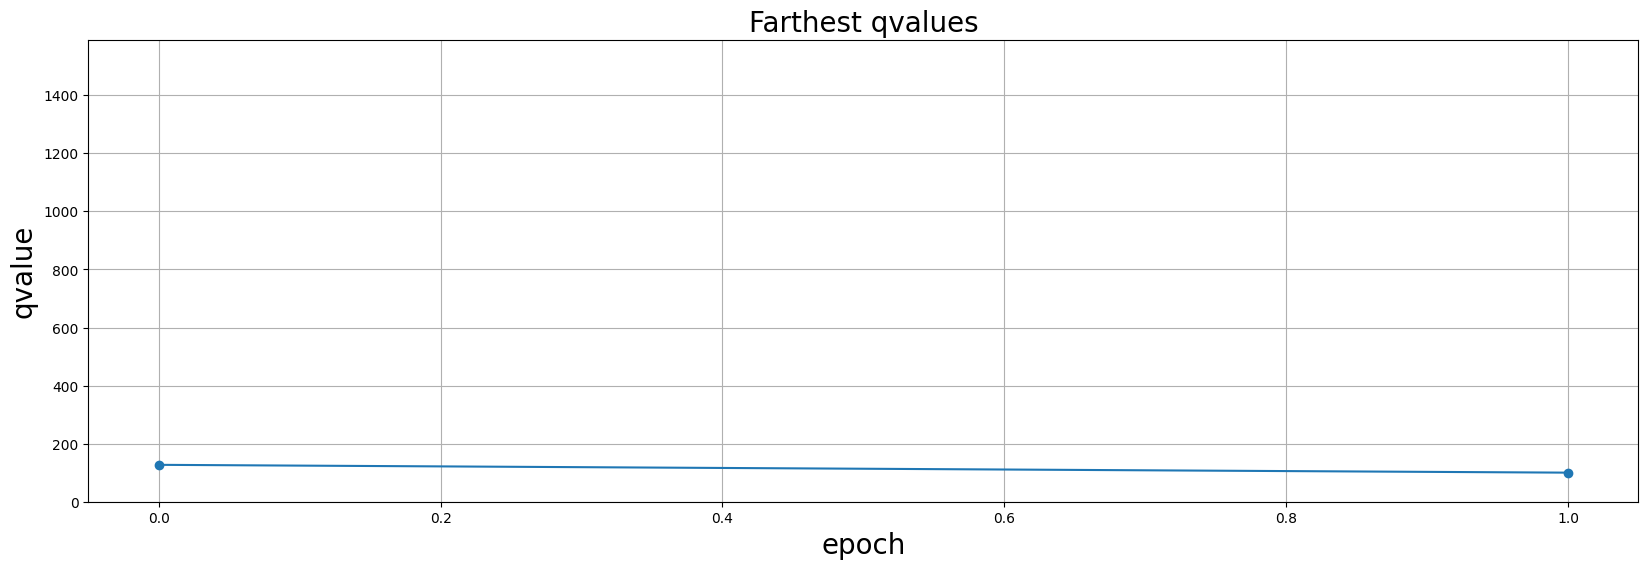

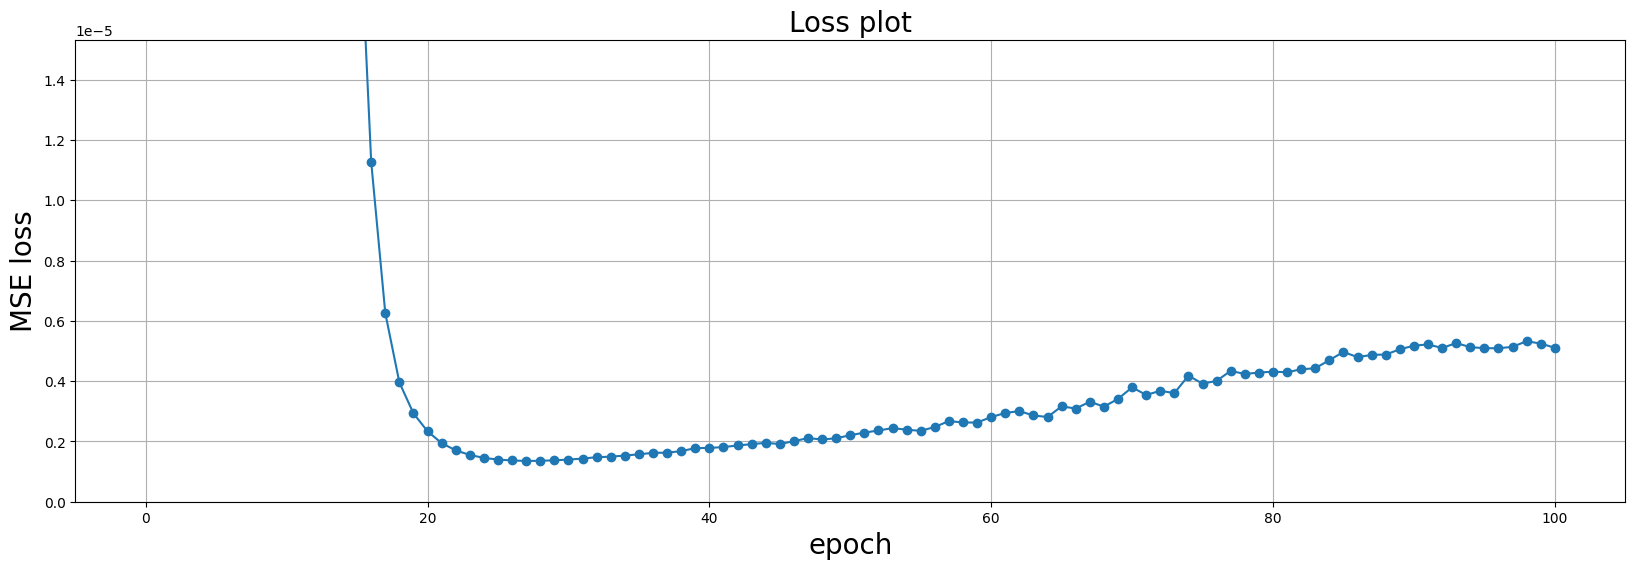

('epoch:', 110, 'train_loss:', 4.757049288061763e-06, 'Time:', 689.76, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 120, 'train_loss:', 4.4263251620344445e-06, 'Time:', 752.02, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 130, 'train_loss:', 4.113112181468564e-06, 'Time:', 814.28, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 140, 'train_loss:', 3.886367476997503e-06, 'Time:', 876.59, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 150, 'train_loss:', 3.872096992764286e-06, 'Time:', 938.9, 'RW 0.58', 'Bellman 2.41', 'Train 3.17')
('epoch:', 160, 'train_loss:', 3.764039221548031e-06, 'Time:', 1001.24, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 170, 'train_loss:', 3.796727617117407e-06, 'Time:', 1063.57, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 180, 'train_loss:', 3.7799756249458896e-06, 'Time:', 1125.89, 'RW 0.59', 'Bellman 2.41', 'Train 3.18')
('epoch:', 190, 'train_loss:', 3.7246980674576066e-06, 'Time:', 1188.22, 'RW 0.58', 'Bellman 2.41', 

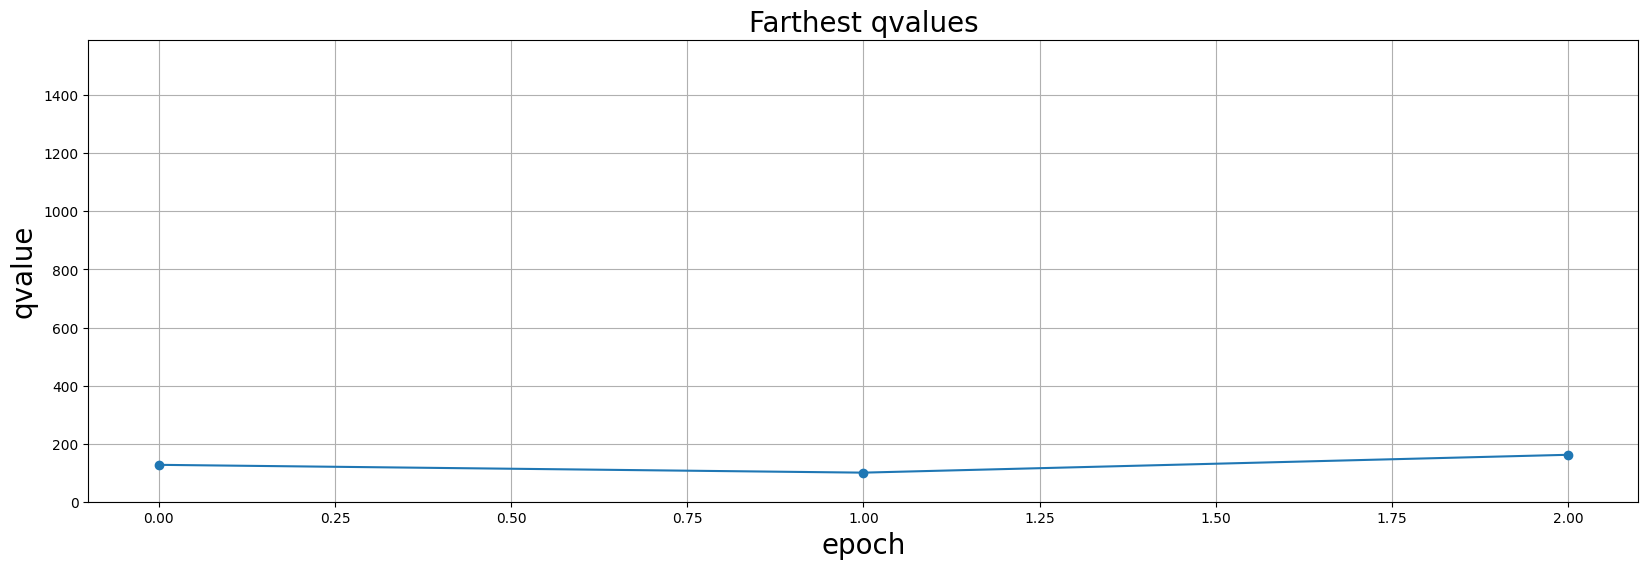

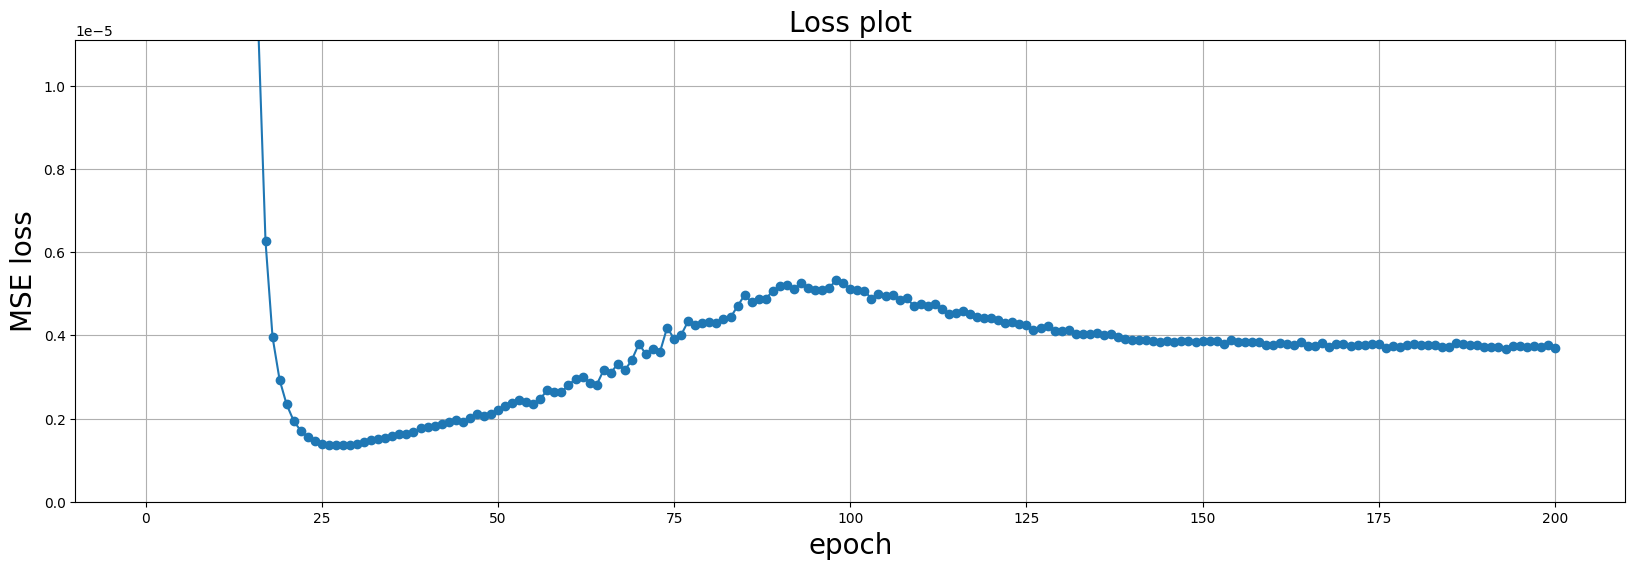

('epoch:', 210, 'train_loss:', 3.7616452728801066e-06, 'Time:', 1313.12, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 220, 'train_loss:', 3.691124745803751e-06, 'Time:', 1375.5, 'RW 0.59', 'Bellman 2.41', 'Train 3.19')
('epoch:', 230, 'train_loss:', 3.650543322842312e-06, 'Time:', 1437.83, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 240, 'train_loss:', 3.6237102572494707e-06, 'Time:', 1500.22, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 250, 'train_loss:', 3.586309999318775e-06, 'Time:', 1562.6, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 260, 'train_loss:', 3.5431047216953875e-06, 'Time:', 1624.99, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 270, 'train_loss:', 3.54255000005991e-06, 'Time:', 1687.34, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 280, 'train_loss:', 3.5684105999315957e-06, 'Time:', 1749.75, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 290, 'train_loss:', 3.554970000806222e-06, 'Time:', 1812.13, 'RW 0.58', 'Bellman 2.4

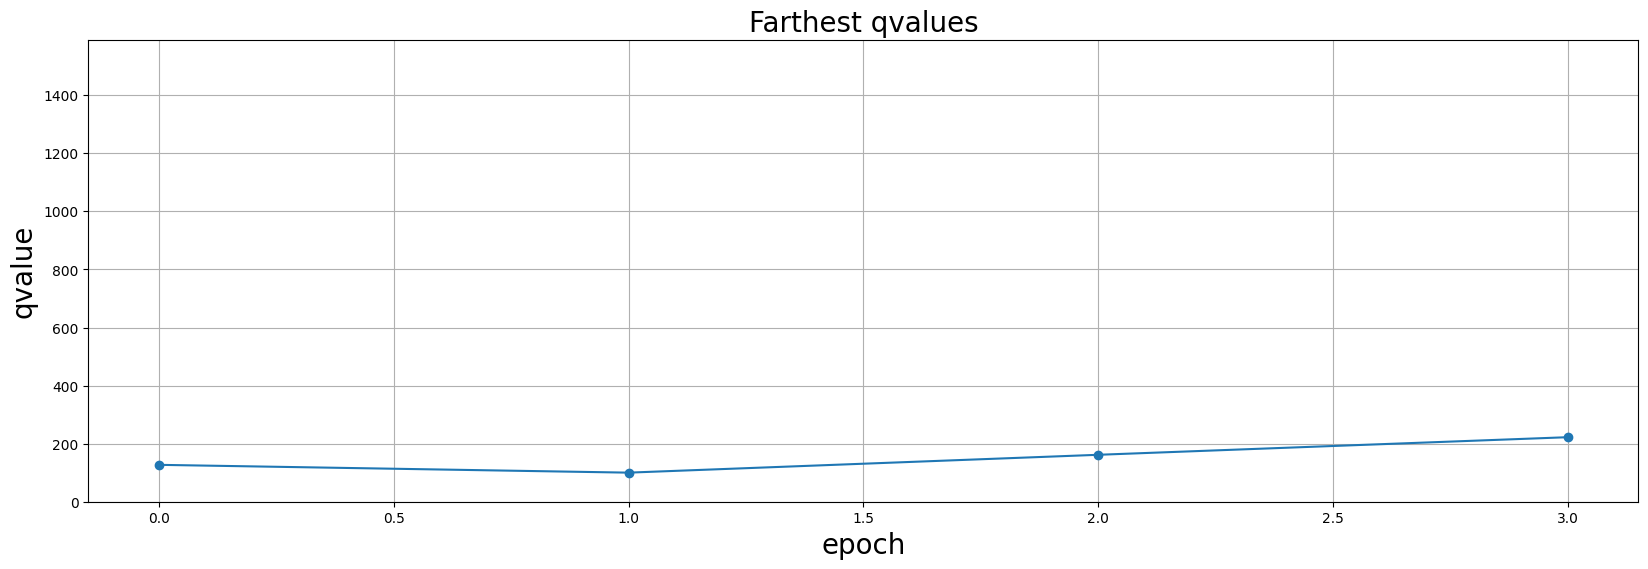

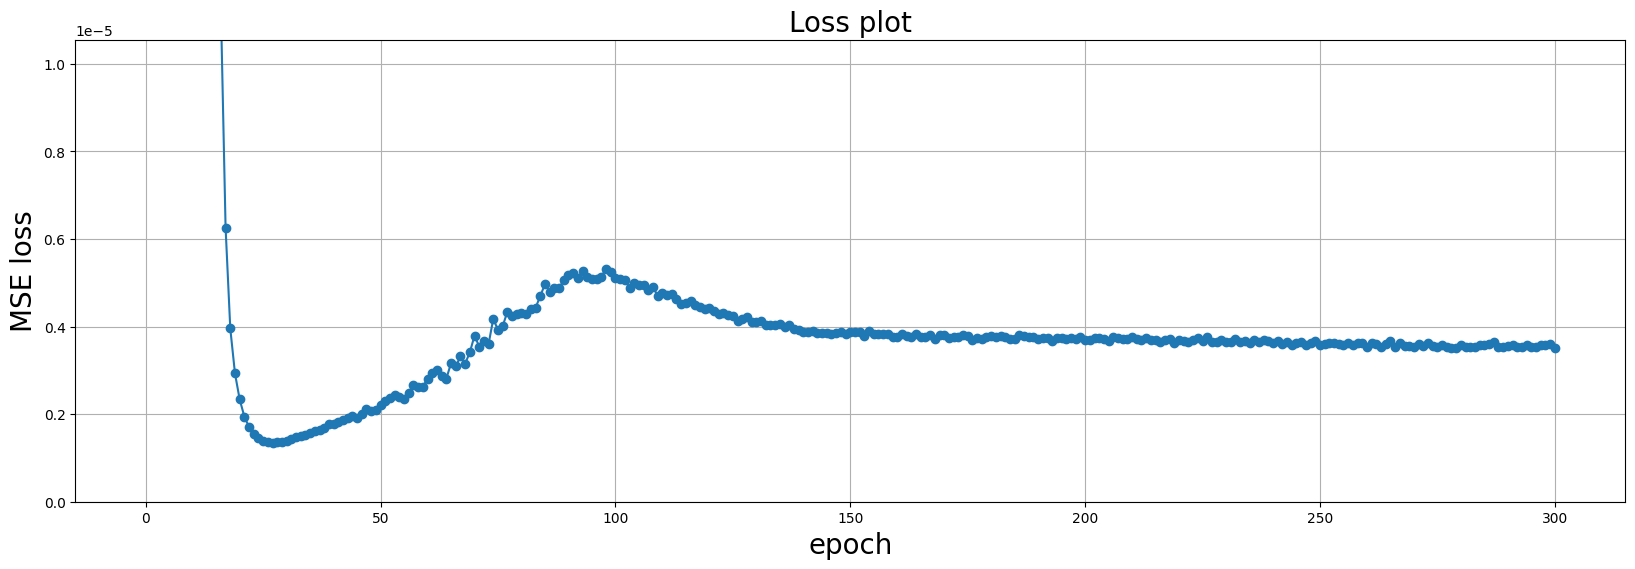

('epoch:', 310, 'train_loss:', 3.5368563605453e-06, 'Time:', 1936.92, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 320, 'train_loss:', 3.514713068029798e-06, 'Time:', 1999.3, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 330, 'train_loss:', 3.6150039757792837e-06, 'Time:', 2061.62, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 340, 'train_loss:', 3.5567649350694516e-06, 'Time:', 2123.96, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 350, 'train_loss:', 3.696116602985093e-06, 'Time:', 2186.32, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 360, 'train_loss:', 3.5978970239784554e-06, 'Time:', 2248.7, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 370, 'train_loss:', 3.5256508372761787e-06, 'Time:', 2310.99, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 380, 'train_loss:', 3.7755823119035527e-06, 'Time:', 2373.36, 'RW 0.58', 'Bellman 2.41', 'Train 3.25')
('epoch:', 390, 'train_loss:', 3.6263388400321133e-06, 'Time:', 2435.72, 'RW 0.58', 'Bellman 2.

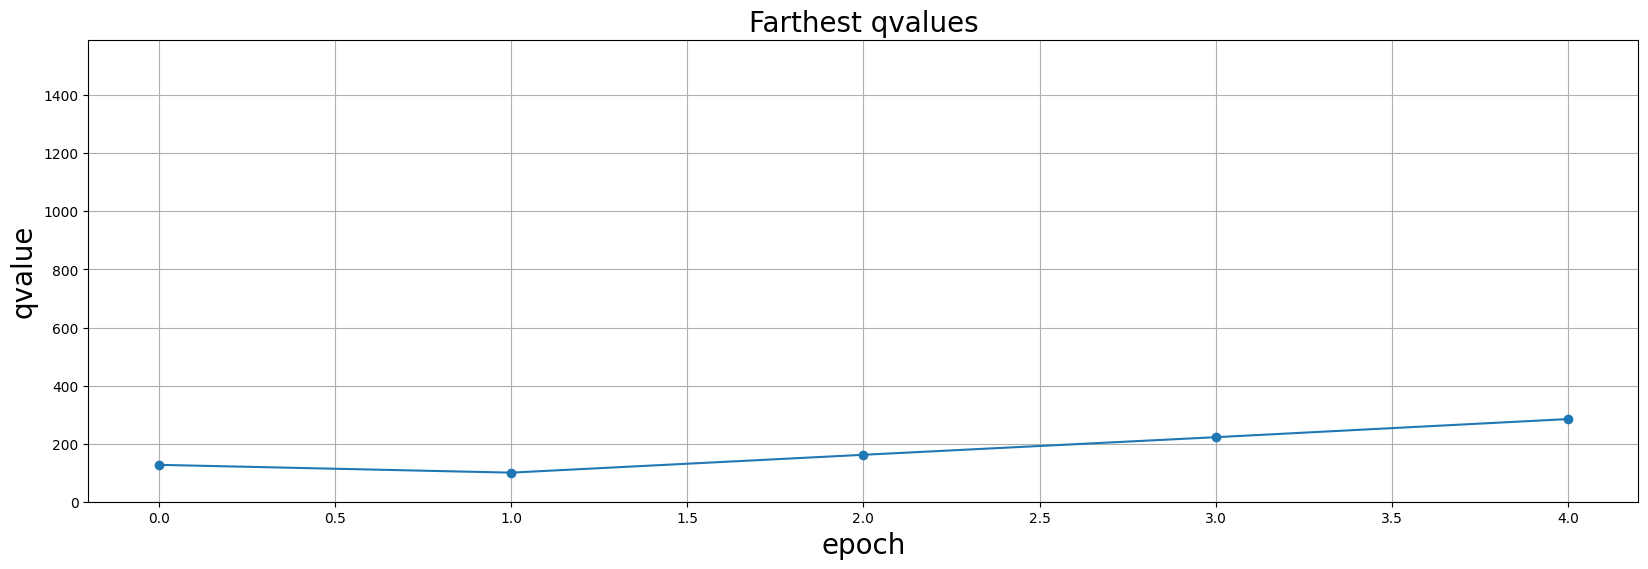

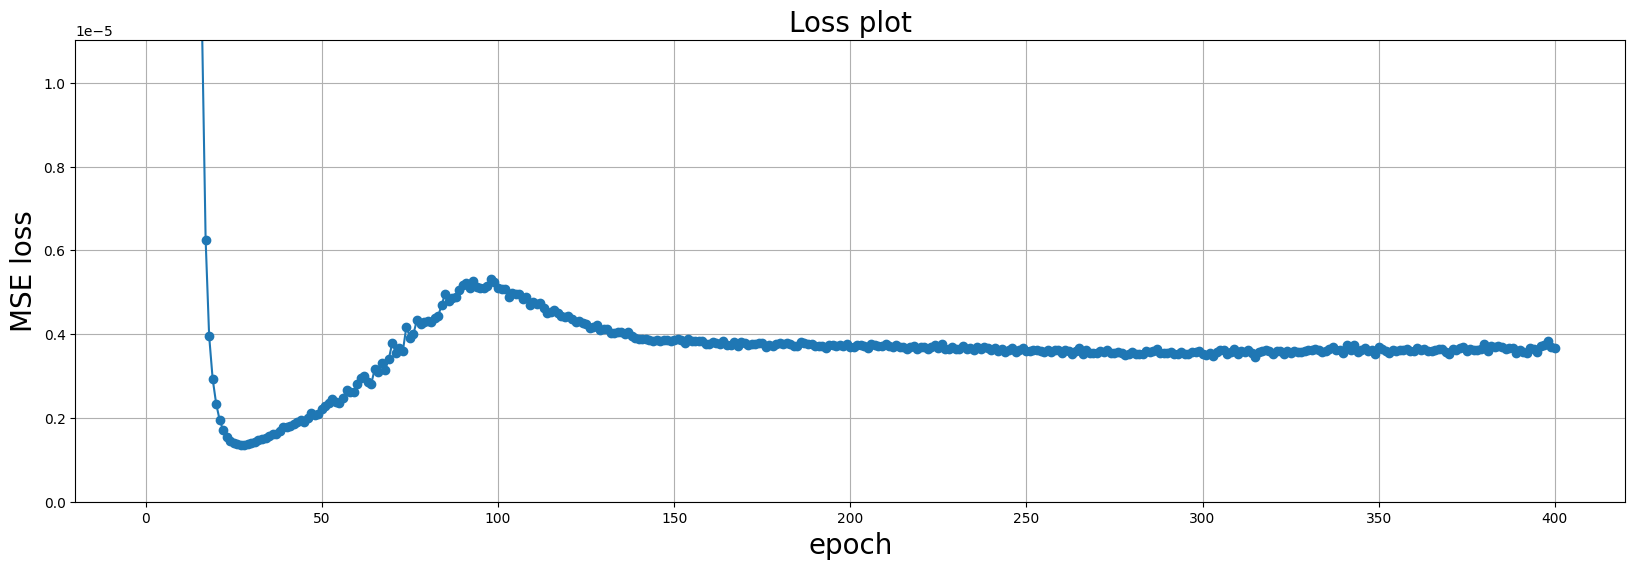

('epoch:', 410, 'train_loss:', 3.713334418143296e-06, 'Time:', 2560.47, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 420, 'train_loss:', 3.712668909541826e-06, 'Time:', 2622.8, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 430, 'train_loss:', 3.7092287730966343e-06, 'Time:', 2685.15, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 440, 'train_loss:', 3.616356185203321e-06, 'Time:', 2747.48, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 450, 'train_loss:', 3.654022132960449e-06, 'Time:', 2809.85, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 460, 'train_loss:', 3.6782359739292732e-06, 'Time:', 2872.15, 'RW 0.58', 'Bellman 2.41', 'Train 3.18')
('epoch:', 470, 'train_loss:', 3.6828085110990213e-06, 'Time:', 2934.46, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 480, 'train_loss:', 3.6196864304593527e-06, 'Time:', 2996.83, 'RW 0.58', 'Bellman 2.41', 'Train 3.19')
('epoch:', 490, 'train_loss:', 3.6157578027636944e-06, 'Time:', 3059.16, 'RW 0.58', 'Bellman 

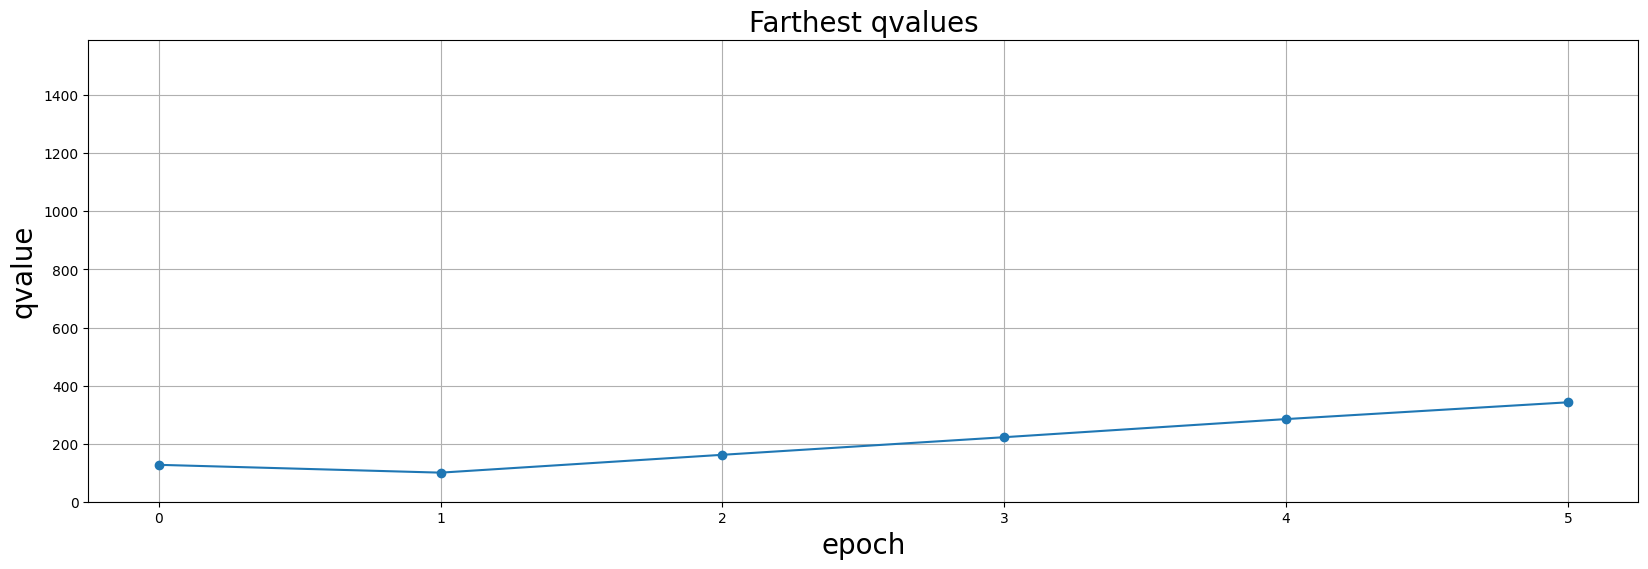

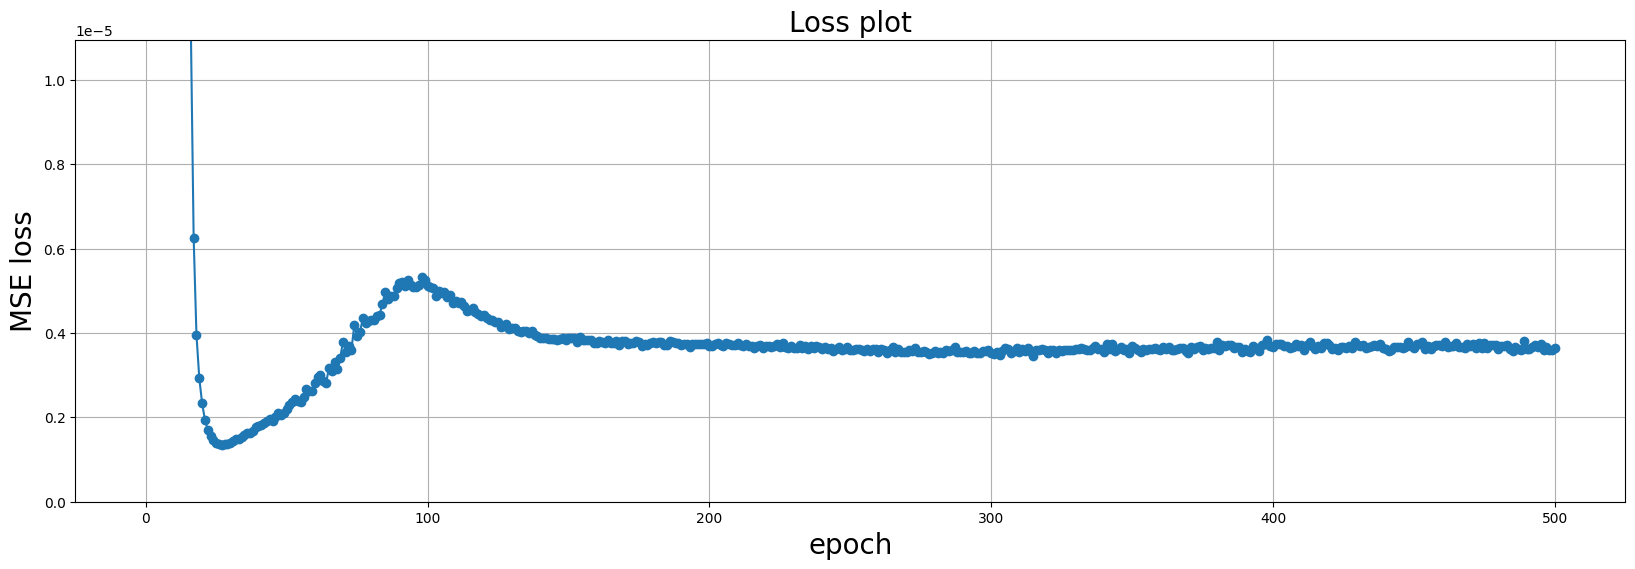

('Training finished. Timing:', 3177.7)


In [25]:
n_epochs_dqn = CFG['n_epochs_dqn']
flag_dqn_round = CFG['flag_dqn_round']
n_random_walks_to_generate = CFG['n_random_walks_to_generate_dqn']
print_logging_info('n_epochs:', n_epochs_dqn)
verbose_loc = 10
t1 = time.time()

if n_epochs_dqn > 0:

    i_epoch_best = 0
    list_epoch_train_loss = []
    list_epoch_bfs_mse_loss = []
    list_epoch_farthest_qvalues = []
    for epoch in range(0, n_epochs_dqn):
        #    torch.cuda.empty_cache()
        tt0 = time.time()
        X_train, y_train = random_walks(list_generators, n_random_walk_length=int(1.0*n_random_walk_length),
                                        n_random_walks_to_generate=n_random_walks_to_generate,
                                        n_random_walks_steps_back_to_ban = n_random_walks_steps_back_to_ban,
                                        random_walks_type = random_walks_type, #'simple',
                                        state_rw_start = state_destination)

        X_train_rand = torch.argsort(torch.rand(1*n_random_walk_length*n_random_walks_to_generate, n, device=device), dim=1)

        if verbose_loc >= 100:
            print_logging_info('Epoch:', epoch ,  'RW-Generation Time: %.1f'%(time.time() - tt0) )
        t_rw = time.time() - tt0

        X_train = torch.cat((X_train, X_train_rand))
        y_train = torch.cat((y_train, torch.full((X_train_rand.size(0),), float('inf'), device=device)))

        # Compute their neigbours
        neigb = get_neighbors(X_train, tensor_generators)
        # print( neigb.shape )

        # Compute model predictions by batches, and Bellman's equation update
        tt0 = time.time()
        n_states_all = X_train.shape[0]
        y_bellman = torch.zeros(X_train.shape[0], device=device, dtype=torch.float)
        model.eval()
        with torch.no_grad():
            for i_start_batch  in range(0,n_states_all,batch_size ):
                i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
                y_pred = model(neigb[i_start_batch:i_end_batch,:,:]) * n_random_walk_length# .view(-1, 8) )
                # Bellman:
                y_pred = 1 + torch.min(y_pred, dim=1)[0]
                # Store results:
                y_bellman[i_start_batch:i_end_batch] = y_pred.reshape(-1,)

        # y_bellman += 1e-3 * y_bellman

        # Boundary conditions and restrictions coming from the diffusion distance
        # Сliping (which also partly induce boundary conditions - they will be set to values less than zero - we need exactly zero )
        y_train = torch.min( y_bellman, y_train  )
        # Clip everthing to 1 and
        y_train = torch.clamp_min(y_train, 1 )
        # Boundary condition - at origin distance is zero:
        # (It is not complete boundary condition - since there can be other states which come to origin after many steps )
        y_train[:n_random_walks_to_generate] = 0
        # X_train[:1*n_random_walks_to_generate] = state_destination
        y_train[(X_train == state_destination).all(-1)] = 0
        # Rounding since distances are integers positive numbers:
        if flag_dqn_round:
            y_train = torch.round( y_train )

        if verbose_loc >= 100:
            print_logging_info('Epoch:', epoch ,  'Bellman Time: %.2f'%(time.time() - tt0) )
        t_bellman = time.time() - tt0

        # Shuffle train data and
        #y_train = y_train.float()
        indices = torch.randperm(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]


        tt0 = time.time()
        model.train()
        # Neural network train by batches (not to crash RAM)
        n_states_all =  X_train.shape[0]
        cc = 0; train_loss = 0.0
        for i_start_batch  in range(0,n_states_all,batch_size ):
            i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )

            # Forward
            outputs = model(X_train[i_start_batch:i_end_batch])
            main_loss = criterion(outputs.squeeze(), y_train[i_start_batch:i_end_batch] / n_random_walk_length)
            loss = main_loss + 0.002 * (outputs.mean() - 0.6).abs()
            # loss = main_loss  # + 0.0002 * (outputs.mean() - 0.7).abs()
            # loss = main_loss + 0.02 * (outputs.mean() - 0.7).abs()
            # Backward and optimization
            optimizer.zero_grad()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += main_loss.item();
            cc+=1
        train_loss /= cc
        list_epoch_train_loss.append( train_loss )

        t_train = time.time() - tt0

        if verbose_loc >= 100:
            print_logging_info('Epoch:', epoch ,  'Optimize Time: %.2f'%(time.time() - tt0) )

            print_logging_info('epoch:', epoch ,'train_loss:', train_loss,'Time:', np.round(time.time()-t1,2) )

        if verbose_loc >= 10:
            if epoch% (verbose_loc) == 0:
                print_logging_info('epoch:', epoch ,'train_loss:', train_loss,'Time:', np.round(time.time()-t1,2),
                     'RW %.2f'%(t_rw),'Bellman %.2f'%(t_bellman),'Train %.2f'%(t_train),    )

        if epoch % 500 == 0:
            torch.save(model.state_dict(), os.path.join(experiment_path, f"model_ep{epoch}_{wm}_cuda{cuda_i}_i_{nni}.pth"))

        if epoch % 100 == 0:
            array_beam_states = state_start.view(1, state_size).clone().to(dtype).to(device)

            for _ in range(3):
                array_new_states = get_neighbors(array_beam_states, tensor_generators).flatten(end_dim=1)
                array_beam_states = torch.cat([array_beam_states, array_new_states], dim=0)

            model.eval()
            with torch.no_grad():
                n_states_all = array_beam_states.shape[0]
                q_value = torch.zeros( n_states_all, device = device )
                for i_start_batch  in range(0,n_states_all,batch_size ):
                    i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
                    q_value[i_start_batch:i_end_batch]  = model(array_beam_states[i_start_batch:i_end_batch ,: ])[..., -1].view(-1) * n_random_walk_length

            list_epoch_farthest_qvalues.append(q_value.mean().item())
            fig = plt.figure(figsize = (20,6 ) )
            plt.plot( list_epoch_farthest_qvalues, 'o-'  )
            plt.ylim(0, 1.2*n_random_walk_length)
            plt.title('Farthest qvalues', fontsize = 20 )
            plt.xlabel('epoch',fontsize = 20 )
            plt.ylabel('qvalue', fontsize=20)
            plt.grid()
            plt.show()

        if epoch % 100 == 0:
            fig = plt.figure(figsize = (20,6 ) )
            plt.plot( list_epoch_train_loss, 'o-'  )
            plt.ylim(0, 3*list_epoch_train_loss[-1])
            plt.title('Loss plot', fontsize = 20 )
            plt.xlabel('epoch',fontsize = 20 )
            plt.ylabel('MSE loss', fontsize=20)
            plt.grid()
            plt.show()

        # if epoch % 100 == 0:
        #     # plt.axis('equal')
        #     plt.grid()
        #     plt.plot(pred_cdf.cpu().numpy());
        #     plt.plot(ref_cdf.cpu().numpy());
        #     plt.show()

        if False:  # epoch % 100 == 0:
            state = state_start.clone()

            states = [state,]
            for p in path:
                move = dict_generators[p]
                state = state[move]
                states.append(state)

            model.eval()
            with torch.no_grad():
                q_value = model(torch.stack(states).long())[..., -1].view(-1) * n_random_walk_length

            plt.axis('equal')
            plt.grid()
            # plt.xlim(0, 128)
            # plt.ylim(0, 128)
            plt.plot(q_value.cpu().numpy()[::-1]);
            plt.plot(range(len(q_value)), alpha=0.25);
            plt.show()

    print_logging_info('Training finished. Timing:', np.round(time.time()-t1, 1) )

In [26]:
epoch

509

In [27]:
experiment_path

'/home/datalab/nfs/group_teory/1card_30may_MrN/1_cuda0_i_106_07_20_2025_18_21_37/'

In [28]:
torch.save(model.state_dict(), os.path.join(experiment_path, f"model_final{wm}_cuda{cuda_i}_i_{nni}.pth"))

In [29]:
with open(os.path.join(experiment_path, f"list_epoch_train_loss{wm}_cuda{cuda_i}_i_{nni}.json"), 'w') as f:
    json.dump(list_epoch_train_loss, f)

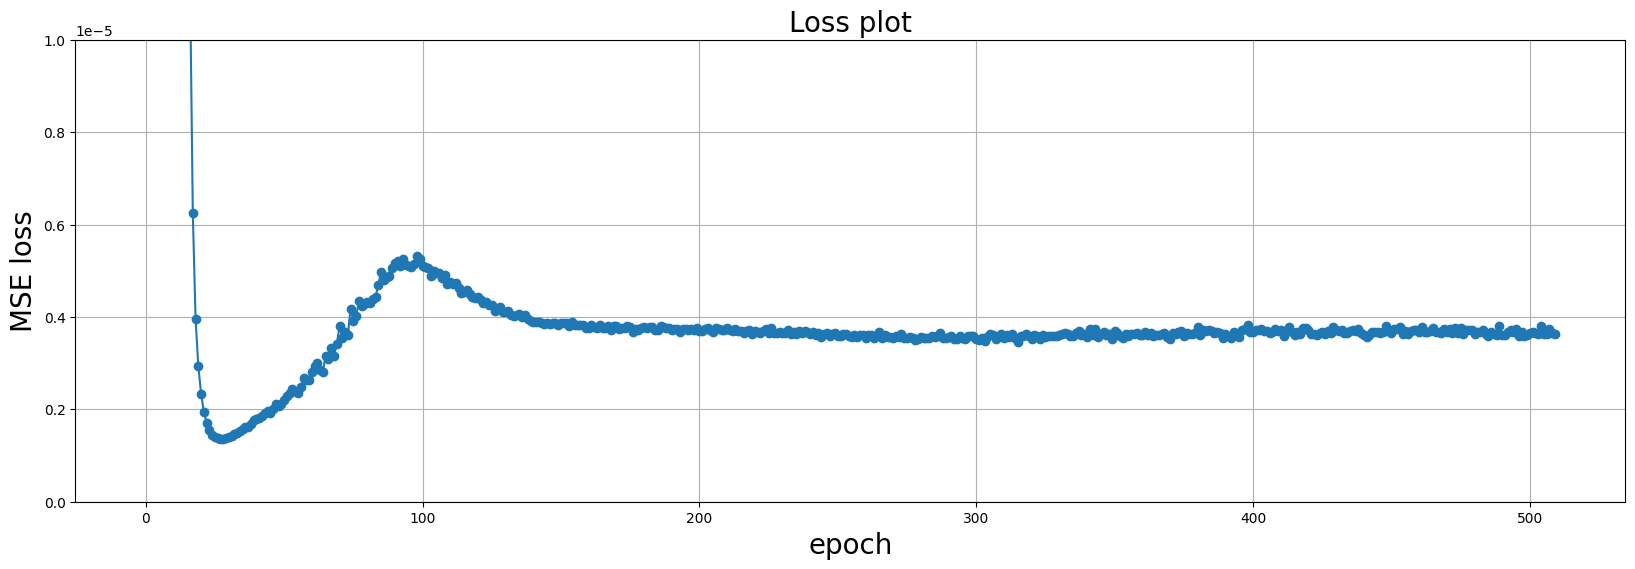

In [30]:
fig = plt.figure(figsize = (20,6 ) )
plt.plot( list_epoch_train_loss, 'o-'  )
plt.ylim(0, 1e-5)
plt.title('Loss plot', fontsize = 20 )
plt.xlabel('epoch',fontsize = 20 )
plt.ylabel('MSE loss', fontsize=20)
plt.grid()
plt.savefig(os.path.join(experiment_path, f"list_epoch_train_loss{wm}_cuda{cuda_i}_i_{nni}.png"))
plt.show()

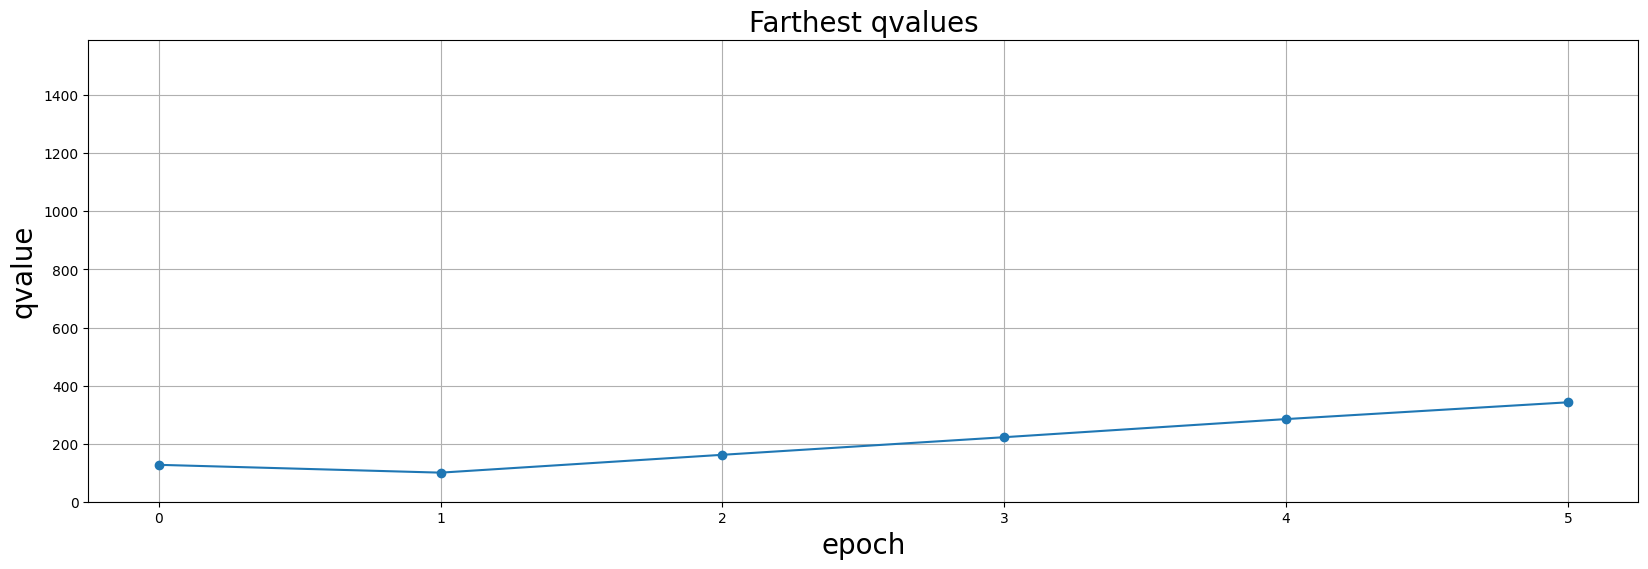

In [31]:
fig = plt.figure(figsize = (20,6 ) )
plt.plot( list_epoch_farthest_qvalues, 'o-'  )
plt.ylim(0, 1.2*n_random_walk_length)
plt.title('Farthest qvalues', fontsize = 20 )
plt.xlabel('epoch',fontsize = 20 )
plt.ylabel('qvalue', fontsize=20)
plt.grid()
plt.savefig(os.path.join(experiment_path, f"fartest_qvalues{wm}_cuda{cuda_i}_i_{nni}.png"))
plt.show()

# Beam Search Torch

In [32]:
def get_unique_states(states: torch.Tensor, vec_hasher = 'Auto',device = 'Auto') -> torch.Tensor:
    '''
    Return matrix with unique rows for input matrix "states"
    I.e. duplicate rows are dropped.
    For fast implementation: we use hashing via scalar/dot product.
    Note: output order of rows is different from the original.

    Note: that implementation is 30 times faster than torch.unique(states, dim = 0) - because we use hashes  (see K.Khoruzhii: https://t.me/sberlogasci/10989/15920)
    Note: torch.unique does not support returning of indices of unique element so we cannot use it
    That is in contrast to numpy.unique which supports - set: return_index = True
    '''

    if vec_hasher == 'Auto':
        device = torch.device(f"cuda:{cuda_i}" if torch.cuda.is_available() else "cpu")

    # Preprare vector which will used for hashing - to avoid revisiting same states
    if vec_hasher == 'Auto':
        max_int =  int( (2**62) )
        dtype_for_hash = torch.int64
        vec_hasher = torch.randint(-max_int, max_int+1, size=(state_size,), device=device, dtype=dtype_for_hash)

    # Hashing rows of states matrix:
    hashed = torch.sum(vec_hasher * states, dim=1) # Compute hashes.
        # It is same as matrix product torch.matmul(hash_vec , states )
        # but pay attention: such code work with GPU for integers
        # While torch.matmul - does not work for GPU for integer data types,
        # since old GPU hardware (before 2020: P100, T4) does not support integer matrix multiplication

    # Sort
    hashed_sorted, idx = torch.sort(hashed)
    # Mask selects elements which are different from the consequite - that is unique elements (since vector is sorted on the previous step)
    mask = torch.concat((torch.tensor([True], device = device),
                         (hashed_sorted[1:] - hashed_sorted[:-1]) != 0))
    return states[idx][mask]

# Test run:
s = get_unique_states(torch.arange(n_permutations_length, device = device ).view(1, -1  ).expand(10, -1 ).clone())
print_logging_info(s)
s.shape,s.dtype

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]],
       device='cuda:0'),)


(torch.Size([1, 52]), torch.int64)

## Beam search params

In [33]:
%%time
print_logging_info(CFG)
print_logging_info()
##################################################################################
# Beam search params
##################################################################################


#beam_width = 1000
beam_width =  CFG['beam_width']
print_logging_info('beam_width:', beam_width)
# Coefficient to combine previous cost and new value typically 0...1 (attenuation of history)
alpha_previous_cost_accumulation = CFG['alpha_previous_cost_accumulation']
print_logging_info('alpha_previous_cost_accumulation:', alpha_previous_cost_accumulation  )
# Maximum steps to make:
n_steps_limit = CFG['n_steps_limit']
print_logging_info('n_steps_limit:',n_steps_limit)

ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted = CFG['ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted']
print_logging_info('ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:',ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted)
beam_search_models_or_heuristics = CFG['beam_search_models_or_heuristics']#  'model_torch'; # 'Hamming'
print_logging_info('beam_search_models_or_heuristics:',beam_search_models_or_heuristics)
batch_size = CFG['batch_size']
print_logging_info('batch_size:', batch_size )
n_steps_back_to_ban = CFG['n_beam_search_steps_back_to_ban']
print_logging_info('n_steps_back_to_ban:',n_steps_back_to_ban)
beam_search_models_or_heuristics = CFG['beam_search_models_or_heuristics']#  'model_torch'; # 'Hamming', 'model_with_predict': # Catboost or Sklearn
print_logging_info('beam_search_models_or_heuristics:',beam_search_models_or_heuristics)


# To implement ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted
# We need the following to known where what is the position of transposition (0,1) in list_generators
state_size = len(list_generators[0])
#X_loc = torch.tensor( [1,0] + list(np.arange(2,state_size)), device = device, dtype = dtype )
X_loc = np.array( [1,0] + list(np.arange(2,n)) )
i_position_X_in_list_generators = -1
for k in range(len(list_generators)):
    if np.all( list_generators[k] == X_loc ) :
        i_position_X_in_list_generators = k
        break
print_logging_info('i_position_X_in_list_generators:',i_position_X_in_list_generators )
verbose = 100

print_logging_info()


print_logging_info('state_destination:', state_destination)
print_logging_info()
print_logging_info('state_start (state to be solved): ', state_start)
print_logging_info()

({'n_permutations_length': 52, 'random_walks_type': 'non-backtracking-beam', 'n_random_walk_length': 1326, 'n_random_walks_to_generate': 1024, 'n_random_walks_steps_back_to_ban': 8, 'model_type': 'MLP', 'list_layers_sizes': [1024, 1024, 1024], 'n_epochs': 100, 'batch_size': 1024, 'lr': 1e-07, 'optimizer_type': 'AdamW', 'weight_decay': 1e-05, 'scheduler': False, 'n_epochs_dqn': 510, 'milestones_dqn': [4000, 4500], 'flag_dqn_round': False, 'n_random_walks_to_generate_dqn': 1024, 'beam_search_torch': True, 'beam_search_Fironov': False, 'beam_width': 1, 'n_steps_limit': 10816, 'alpha_previous_cost_accumulation': 0, 'beam_search_models_or_heuristics': 'model_torch', 'ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted': False, 'n_beam_search_steps_back_to_ban': 32, 'solve_random_or_longest_state': 'solve_LRX_longest'},)
()
('beam_width:', 1)
('alpha_previous_cost_accumulation:', 0)
('n_steps_limit:', 10816)
('ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:', False)
('beam_search_mo

## Beam search torch main loop

In [34]:
# %%time
all_found_path_lengths = {}
for beam_width in [65536, 8192, 1024, 64, 32, 16, 1]:
    found_path_lengths = []
    for attempt in range(5):
        n_generators = len(list_generators)

        t0 = time.time()

        flag_found_destination = False


        if 1:
            # Initialize array of states
            array_beam_states = state_start.view(1, state_size  ).clone().to(dtype).to(device)


            # Hash initial states. Intialize storage
            if n_steps_back_to_ban > 0:
                # Hashes via vector product - extremely simple and fast
                # Implementation - equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
                hash_initial_state = torch.sum( state_start.view(-1, state_size  ) * vec_hasher, dim=1) # Compute hashes
                # Storage for hashes - 2d array:
                vec_hashes_current = hash_initial_state.expand( beam_width * n_generators  , n_steps_back_to_ban ).clone()
                # Intialize index for hash storage
                # Newly obtained hash vectors will be stored in 2d array vec_hashes_current
                # The position/column for storage: i_cyclic_index_for_hash_storage
                i_cyclic_index_for_hash_storage = 0 # Will be updated modula n_steps_back_to_ban, i.e. from 0 to n_steps_back_to_ban-1

            ##########################################################################################
            # Main loop
            # 1. Apply all moves to all states in current beam - get new states candidates
            # 2. Select only unique states - that appears to be critical - otherwise beam becomes over-populated by duplicates and all the diversity ideas is lost
            # 3. Check  destination-state:  found or not
            # 4. Select those states which were not visited on "NNN" previous steps. To make it fast we uses hashes:
            # 4.1. Compute hashes of these states just by scalar multiplication on random hash vector - get single int64 as a hash
            # 4.2. Choose only those states which hashes are new - not in the stored history of hashes
            # 5 Compute value function for all states - model prediction or heuristics
            # 5b Select only desired number of states - beam_width "best" states
            ##########################################################################################
            for i_step in range(1,n_steps_limit+1):
                t_moves = t_hash = t_isin =  0; t_full_step = time.time() # Time profiling
                t_unique_els = 0

                # 1. Create new states:
                # Apply all generators to all current states at once
                # array_new_states: 2d array (n_random_walks_to_generate * n_generators  ) x state_size
                t1 = time.time()
                if not ban_p0_p1_transposition_if_p0_lt_p1_ie_already_sorted:
                    array_new_states = get_neighbors(array_beam_states,tensor_generators  ).flatten(end_dim=1) # Flatten converts 3d array to 2d

                else:
                    # Basically same as above - result will be application of all moves to all beam states
                    # but do it move by move, in order to check specific heuristic condition for some moves
                    # I.e. implement  "Fironov's X-condition check"
                    # That is not apply transposition (0,1) if v[0],v[1] are already sorted

                    # Prepare storage for new states:
                    array_new_states = torch.empty( (0,array_beam_states.shape[1]) , device=device, dtype = dtype)

                    # Technical preparation: to apply permutations to array we need the trick:
                    # naively it is: array[ :, IX_array], but actually we need  to write array[ range(N)[:, np.newaxis], IX_array  ]
                    row_indices = np.arange( array_beam_states.shape[0] )[:, np.newaxis]

                    # Loop over moves:
                    for ii1, move in enumerate(list_generators):

                        if (ii1 != i_position_X_in_list_generators):
                            # Make move - one move to all beam states at once:
                            array_states_tmp = array_beam_states[row_indices,move]

                        else:
                            # Make moves with exceptions:
                            # Do not make transposition of 0,1 if they are already sorted:
                            mask_X_condtion = array_beam_states[:,0] > array_beam_states[:,1]
                            row_indices = np.arange( mask_X_condtion.sum().item() )[:, np.newaxis]
                            array_states_tmp = array_beam_states[mask_X_condtion][row_indices,move]

                        # array_states_tmp = get_unique_states(array_states_tmp) # Do this later - Can do it for all states at once later for speed-up

                        array_new_states = torch.concatenate([array_new_states, array_states_tmp],axis = 0)

                t_moves += (time.time() - t1)

                # 2. Take only unique states
                # surprise: THAT IS CRITICAL for beam search performance !!!!
                # if that is not done - beam search  will not find the desired state - quite often
                # The reason - essentianlly beam can degrade, i.e. can be populated by copy of only one state
                # It is surprising that such degradation  happens quite often even for beam_width = 10_000 - but it is indeed so
                t1 = time.time()
                array_new_states = get_unique_states(array_new_states)
                t_unique_els += (time.time() - t1)

                # 3. Check destination state found
                vec_tmp = torch.all(array_new_states == state_destination, axis =1) # Compare state_destination and each row array_of_states
                flag_found_destination = torch.any(vec_tmp).item() # Check for coincidence
                if flag_found_destination:
                    if verbose >= 1:
                        print_logging_info('Found destination state. ', 'i_step:', i_step, ' n_ways:', (vec_tmp).sum())
                    break

                # 4. Nonbacktracking - forbid visits states visited before
                if n_steps_back_to_ban > 0:
                    # 4.1 Compute hashes
                    # Compute hash. For non-backtracking, i.e. selection of  states, which were not visited  before.
                    t1 = time.time()
                    vec_hashes_new = torch.sum(array_new_states * vec_hasher, dim=1) # Compute hashes
                    # That is equivalent to matmul, but matmul is not supported for ints in torch (on GPU <= 2018) - that is way round
                    t_hash += (time.time() - t1)
                    #  print('hashed', t_hash )

                    # 4.2 Select only states not seen before
                    # Nonbacktracking - select states not visited before
                    t1 = time.time()
                    mask_new = ~torch.isin(vec_hashes_new, vec_hashes_current.view(-1), assume_unique=False)
                    t_isin += (time.time() - t1)
                    mask_new_sum = mask_new.sum().item()
                    if mask_new_sum > 0 :
                        # Select only new states - not visited before
                        array_new_states = array_new_states[mask_new,:]
                    else:
                        # Stagnation cannot find new states
                        # In futute versions consider restarts
                        flag_found_destination = False
                        # i_step = -1
                        if verbose >= 1:
                            print_logging_info('Cannot find new states. i_step:',i_step, )
                        break
                    # Update hash storage
                    # Pay attention - we store hashes for ALL obtained states not only for those selected - that gives us improvement:
                    # We improve the chances that states obtaine on i_step will be on true graph distance i_step - our ideal goal.
                    # Which might not always be the case since random walk may create loops.
                    # All the states which are achieved - they need not more than i_step steps - so it is better to ban them all
                    # Thus we improve chances that the next states will increase the true graph distance
                    i_cyclic_index_for_hash_storage = (i_cyclic_index_for_hash_storage + 1 ) % n_steps_back_to_ban
                    i_tmp = len(vec_hashes_new)
                    vec_hashes_current[:i_tmp, i_cyclic_index_for_hash_storage ] = vec_hashes_new

                # 5. Estimate states and select top beam_width ones
                # ML-model inference - estimate distance of new states to the destination state
                t0 = time.time()
                q_value = torch.tensor([0])
                if array_new_states.shape[0] > beam_width: # If we have not so many states - we take them all - no need for ML-model

                    # Compute heuristic distance to destination state
                    if beam_search_models_or_heuristics == 'model_torch':
                        model.eval()
                        with torch.no_grad():
                            n_states_all = array_new_states.shape[0]
                            q_value = torch.zeros( n_states_all, device = device )
                            for i_start_batch  in range(0,n_states_all,batch_size ):
                                i_end_batch = min( [i_start_batch + batch_size,  n_states_all ] )
                                q_value[i_start_batch:i_end_batch]  = model(array_new_states[i_start_batch:i_end_batch ,: ]).view(-1) * n_random_walk_length
                        # Get indices of the smallest `beam_width` values
                        if attempt == 0:
                            idx = torch.argsort(q_value)[:beam_width]
                        else:
                            idx = torch.argsort(q_value.round()+torch.rand_like(q_value) * 1e-6)[:beam_width]
                        # Select rows based on the indices
                        array_beam_states = array_new_states[idx, :]
                    elif beam_search_models_or_heuristics == 'model_with_predict': # Catboost or Sklearn

                        # ML-model inference - estimate distance of new states to the destination state
                        q_value = model.predict(array_new_states.detach().cpu().numpy() )
                        # Take only "beam_width" of the best states (i.e. most nearest to destination according to the model estimate)
                        idx = np.argsort(q_value)[:beam_width]
                        array_beam_states = array_new_states[idx,:]

                    elif beam_search_models_or_heuristics == 'Hamming':
                        # Here it is Hamming distance, but can be neural net predictor:
                        q_value = torch.sum( (array_new_states - state_destination ) !=0 , axis = 0 )
                        # Get indices of the smallest `beam_width` values
                        idx = torch.argsort(q_value)[:beam_width]
                        # Select rows based on the indices
                        array_beam_states = array_new_states[idx, :]
                    else:
                        raise Exception("Unrecognized models_or_heuristics: " + str( beam_search_models_or_heuristics ))

                else:
                    array_beam_states = array_new_states
                predict_time = time.time() - t0

                if verbose >= 10:
                    if (i_step-1) % 10 == 0:
                        if isinstance(q_value, torch.Tensor): q_value = q_value.detach().cpu().numpy()
                        t_full_step = time.time()-t_full_step
                        print_logging_info('Step:',i_step, #  'Visited states:', len(set_seen_states),
                            'Beam (not cummulative) min:',  '%.2f'%np.min( q_value),
                            'median:',  '%.2f'%np.median( q_value),
                            'max:',  '%.2f'%np.max( q_value))
                if verbose >= 100:
                    if (i_step-1) % 15 == 0:
                        print_logging_info('Time: %.1f'%(time.time() - t0 ),'t_moves  %.3f, t_hash  %.3f, t_isin %.3f, t_unique_els  %.3f, t_full_step %.3f'%(t_moves ,
                            t_hash , t_isin , t_unique_els, t_full_step))


                #raise Exception("Just stop here")

        print_logging_info()
        print_logging_info(CFG)

        print_logging_info()
        print_logging_info('beam_width:', beam_width)
        print_logging_info('n=',len(list_generators[0] ) )
        print_logging_info('n(n-1)/2=', int(n*(n-1)/2))
        print_logging_info('Found Path Length:', i_step , 'flag_found_destination:',flag_found_destination, )
        found_path_lengths.append(i_step if flag_found_destination else None)
        #print(path_found)
    all_found_path_lengths[beam_width] = found_path_lengths

all_found_path_lengths

('Step:', 1, 'Beam (not cummulative) min:', '0.00', 'median:', '0.00', 'max:', '0.00')
('Time: 0.0', 't_moves  0.000, t_hash  0.000, t_isin 0.001, t_unique_els  0.000, t_full_step 0.001')
('Step:', 11, 'Beam (not cummulative) min:', '0.00', 'median:', '0.00', 'max:', '0.00')
('Time: 0.0', 't_moves  0.000, t_hash  0.000, t_isin 0.001, t_unique_els  0.000, t_full_step 1753038877.985')
('Step:', 21, 'Beam (not cummulative) min:', '339.49', 'median:', '345.96', 'max:', '353.19')
('Step:', 31, 'Beam (not cummulative) min:', '339.61', 'median:', '345.59', 'max:', '353.02')
('Time: 0.1', 't_moves  0.000, t_hash  0.000, t_isin 0.001, t_unique_els  0.022, t_full_step 0.084')
('Step:', 41, 'Beam (not cummulative) min:', '338.85', 'median:', '345.23', 'max:', '351.73')
('Time: 0.0', 't_moves  0.000, t_hash  0.000, t_isin 0.001, t_unique_els  0.021, t_full_step 1753038879.808')
('Step:', 51, 'Beam (not cummulative) min:', '338.18', 'median:', '344.88', 'max:', '351.10')
('Step:', 61, 'Beam (not cu

KeyboardInterrupt: 

# Final Timing

In [ ]:
all_found_path_lengths

{65536: [1404, 1404, 1432, 1444, 1440],
 8192: [6974, 1502, 3256, 2724, 2678],
 1024: [2336, 2090, 3748, 1684, 3808],
 64: [10388, None, 2570, None, 2236],
 32: [None, None, None, None, None],
 16: [None, None, None, None, None],
 1: [None, None, None, None, None]}

In [ ]:
with open(os.path.join(experiment_path, f"all_found_path_lengths{wm}_cuda{cuda_i}_i_{nni}.json"), 'w') as f:
    json.dump(all_found_path_lengths, f)

In [ ]:
print_logging_info('%.1f seconds passed total '%(time.time()-t0start) )
print_logging_info('%.1f minutes passed total '%( (time.time()-t0start)/60)  )
print_logging_info('%.2f hours passed total '%( (time.time()-t0start)/3600)  )

('30336.7 seconds passed total ',)
('505.6 minutes passed total ',)
('8.43 hours passed total ',)


In [ ]:
%run ./1_5438219454834048919_card0.ipynb